# Libraries 

In [18]:
# ---- Libraries ----

# --- Plonk for reading and analysing dumps ---
import plonk
from plonk.utils.visualize import plot_smoothing_length
from plonk.visualize.interpolation import interpolate
#from plonk.analysis.sph import derivative

# --- Stuff for plots ---
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#plt.rcParams["text.usetex"] =False

# --- You know what this is ---
import numpy as np
#from PyAstronomy import pyaC

# --- Stuff for integrals ---
from scipy.integrate import quad
from scipy.integrate import simps

# --- Stuff for interpolations ---
import scipy.interpolate as interp
from scipy.interpolate import RectBivariateSpline

# --- Utils ---
from scipy.optimize import fsolve # used to check (t, eta) <-> (R, phi) transforms
#from scipy.ndimage.filters import uniform_filter1d

# --- Various constants (may be redundant) ---
import astropy.constants as c
from scipy.constants import G as G_SI
import copy as cp

M_sun = 1.9891e33  # g
G = plonk.units.gravitational_constant     
AU_in_cm = 1.49598073e13
M_sun_to_M_jup = 1.9891e33 / 1.89819e30

In [2]:
# --- Reading and importing the Analytics ---
import os
import sys
sys.path.insert(0, './Analytical_Kinks-master') # choose appropriate path 
import ChannelMaps_functions_test as f # Use ChannelMaps_functions
import ChannelMaps_settings as s

file = "./Analytical_Kinks-master/Deposito_Immagini/Mmp_050_hrp_010_accr_hres/ChannelMaps.param" # choose appropriate path

s.init(file)
dir = "./Analytical_Kinks-master/" + s.name +"/" # choose appropriate path

  * mth = 0.6943937659502745, betap =0.8347537054168793
  * xlim = (77.98861933019018,122.01138066980982), ylim = (-22.011380669809817,22.011380669809817)


# Snapshots loading

In [3]:
# --- Path to the location of the dumps --- 
dump_location = "./dumps/Corrected_dumps/"

Table helping me to remember the dump names

| h/r-Mmp | 0.50    | 0.75   | 1.00  | 1.25  | 2 | 3 |
|:------|:--:|:--:|:--:|:--:|:--:|:--:|
| 0.075 | 49 | 42 | 37 | 34 | -- | 29 |
| 0.100 | 41 | 36 | 32 | 29 | -- | 25 |
| 0.125 | 35 | 31 | 28 | 26 | -- | 22 |
| 0.150 | 31 | 27 | 25 | 24->46 | 21 | 19 |

In [4]:
# --- Loading Snapshot and setting units --- 
snap = plonk.load_snap(dump_location + 'hres_00006.h5')
snap.set_units(position='au', density='g/cm^3', velocity='cm/s', radius_cylindrical='au', velocity_radial_cylindrical='km/s',
              projection='cm', pressure='g/cm/s^2')

<plonk.Snap "hres_00006.h5">

# Sinks analysis

In [6]:
# --- Reading Star mass ---
M_star = snap.sinks[0]['mass'] # Star mass after accretion
M_star_accr = snap.sinks[0]['mass_accreted'] # Mass accreted on the star
print('The star mass is '+str(M_star.m/M_sun*1e3)+r' $M_\odot$. It has accreted ' +
      str(M_star_accr.m/M_sun*1e3) + r' $M_\odot$')

The star mass is 1.0000603723049448 $M_\odot$. It has accreted 6.037230000009484e-05 $M_\odot$


In [8]:
# --- Reading planet properties ---
planet = snap.sinks[1]

### Planet Mass

In [9]:
print('The planet mass is '+str(planet['mass'].m/1.89819e27)+r' $M_{\rm J}$. It has accreted ' +
      str(planet['mass_accreted'].m/1.89819e27) + r' $M_{\rm J}$')

The planet mass is 0.39530199954425427 $M_{\rm J}$. It has accreted 0.06197920289865029 $M_{\rm J}$


In [10]:
# --- Converting to thermal mass ---
(planet['mass'].m/1.89819e27)/s.mth

0.5692764234472719

Table with planet masses for my sims

| h/r-Mmp | 0.50    | 0.75   | 1.00  | 1.25  | 2 | 3 |
|:------|:--:|:--:|:--:|:--:|:--:|:--:|
| 0.075 | 1.18 | 1.61 | 1.93 | 2.23 | -- | 4.49 |
| 0.100 | 0.86/0.58/0.66 | 1.22 | 1.52 | 1.79 | -- | 3.87 |
| 0.125 | 0.72 | 1.04 | 1.32 | 1.59 | -- | 3.58 |
| 0.150 | 0.64 | 0.94 | 1.21 | 1.47 | 2.35 | 3.42 |

### Planet Position

In [11]:
planet['position']

Magnitude,[89.71244784770053 42.429982633962176 0.001523557253754219]
Units,astronomical_unit


-0.4417787682919392


<AxesSubplot:xlabel='x [au]', ylabel='y [au]'>

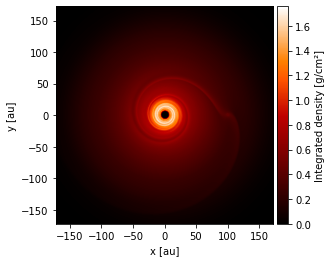

In [12]:
# --- Snap rotation ---
# If the planet is not in the origin, rotate the snapshot (so that Phi_p = 0)

angle = -np.arctan2(planet['position'][1].m,planet['position'][0].m) # Phi_p needed for the rotation
axis = [0, 0, 1] # rotation axis
print(angle)

snap.rotate(axis=axis, angle=angle) #rotation

snap.image(quantity='density', cmap='gist_heat') 

In [13]:
# --- Planet radius ---

limits = (planet['position'][0].m - s.x_match*s.l/0.6, planet['position'][0].m + s.x_match*s.l/0.6,
          planet['position'][1].m - s.x_match*s.l/0.6, planet['position'][1].m + s.x_match*s.l/0.6) # limits for zoom in plots

r_planet = np.sqrt(planet['position'][0]**2 + planet['position'][1]**2)
r_planet

99.24024750646646 <Unit('astronomical_unit')>

In [15]:
# If the planet migrates, evaluate the disc aspect ratio at the correct position and use it in the analytics
initial_radius = 100
hrp = 0.100*(r_planet.m/initial_radius)**(-s.q + 1/2) 
print(hrp)

# If the analytics already consider the right value, read it from there
hrp = s.hr

0.09980951831835169


# Extra Quantities

## Velocity Perturbations

In [50]:
# --- Disc Extent ---
a = 150 * plonk.units('au')
extent = (-a, a, -a, a)
a_in = 100 * plonk.units('au')
extent_in = (-a_in, a_in, -a_in, a_in)

Table with the values of coefficient and exponent used in my sims 

Format: (a * b) -> corr = [1 - a * (hrp)^2 * (R/r_p)^b]^0.5

| h/r-Mmp | 0.50    | 0.75   | 1.00  | 1.25  | 2 | 3 |
|:------|:--:|:--:|:--:|:--:|:--:|:--:|
| 0.075 | 2.5 * 1 | 2.2 * 0.6 | 1.8 * 0.6 | 1.5 * 0.6 | -- | 0.7 * 0.8 |
| 0.100 | 3 * 1.05/2.1 * 3.2/2.1 * 2.9 | 2.5 * 1 | 2 * 0.9 | 1.5 * 0.5 | -- | 0.6 * 1 |
| 0.125 | 2.9 * 0.9 | 2.5 * 0.9 | 2.3 * 0.95 | 1.5 * 0.5 | -- | 0.5 * 1.2 |
| 0.150 | 2.9 * 0.9 | 2.5 * 0.8 | 2.1 * 0.8 | 1.8 * 0.8 -> 1.3 * 0.9 | 0.9 * 1.2 | 1 * 1.5 |

In [17]:
# --- Azimuthal Velocity Perturbations ---

dele = False # If you need to modify the quantities, delete existing arrays first (I found no other way)
if dele == True:
    del snap['azimuthal_velocity']
    del snap['vK']
    del snap['vK_corrected']
    del snap['azimuthal_velocity_pert']
    del snap['azimuthal_velocity_pert_alt']

v_phi = (- snap['y'].to('cm') * snap['velocity'][:,0].to('cm/s') + snap['x'].to('cm') * snap['velocity'][:,1].to('cm/s'))/snap['radius_cylindrical'].to('cm') # Azimuthal velocity field
corr = (1 - 2.1* (hrp)**2 * (snap['radius_cylindrical']/r_planet)**3.2)**0.5 # sub-Keplerian correction. 
                                                                             # I manually changed the coefficient and 
                                                                             # the exponent for each simulation trying to solve
                                                                             # the accretion effects
v_K = np.sqrt(G * M_star / (snap['radius_cylindrical'])).to('cm/s') # Keplerian velocity

# --- Creating arrays ---
snap['azimuthal_velocity'] = v_phi 
snap['vK'] = v_K
snap['vK_corrected'] = v_K * corr
snap['azimuthal_velocity_pert'] = snap['azimuthal_velocity'] - v_K * corr
snap['azimuthal_velocity_pert_alt'] = snap['azimuthal_velocity'] - v_K
snap.set_units(azimuthal_velocity = 'km/s')
snap.set_units(azimuthal_velocity_pert = 'km/s')
snap.set_units(vK_corrected = 'km/s')

C:\Users\faisa\Anaconda3\lib\site-packages\pint\quantity.py:1496: RuntimeWarning: invalid value encountered in sqrt
  magnitude = new_self._magnitude ** exponent
INFO - set_units - adding array azimuthal_velocity to default_units dict
INFO - set_units - adding array azimuthal_velocity_pert to default_units dict
INFO - set_units - adding array vK_corrected to default_units dict


<plonk.Snap "hres_00006.h5">

WARNING - _convert_units_for_cmap - vmin has no units, assuming same units as quantity
WARNING - _convert_units_for_cmap - vmax has no units, assuming same units as quantity
C:\Users\faisa\Anaconda3\lib\site-packages\plonk\visualize\plots.py:130: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  interpolated_data, origin='lower', extent=extent, norm=norm, **_kwargs


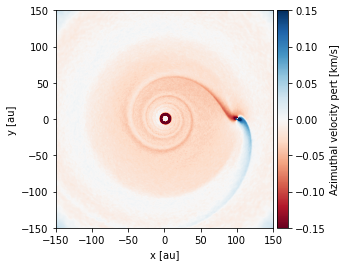

In [19]:
# --- Cheking the result ---
indices = snap.sinks[1].indices

ax = snap.image(
    quantity='azimuthal_velocity_pert',
    extent = extent,
    x='x',
    y='y',
    interp='slice',
    cmap='RdBu',
    vmin = -0.15,
    vmax = 0.15
)

plot_smoothing_length(snap=snap.sinks, indices=indices, alpha=1, ax=ax)

## Density Perturbation

In [20]:
# --- Loading Profiles ---
#profile0 = plonk.load_profile(sim.snaps[0], cmin='5 au', cmax='150 au', n_bins=50)
profile = plonk.load_profile(snap, cmin='5 au', cmax='150 au', n_bins=50)

In [23]:
# --- Creating Profiles ---
r_ = np.linspace(5, 150, 50) 
S0 = 0.423 * plonk.units('g/cm^2') # Sigma_p from sims, needs to be corrected with inner disc cutoff
#S0 = 0.328674435/(1 - np.sqrt( 5/100)) * plonk.units('g/cm^2')

f_prof = profile.to_function('surface_density') # Surface density profile creation
Sigma_prof = f_prof(r_*plonk.units('au')).to('g/cm^2') # Surface density profile evaluation

fL_prof = profile.to_function('angular_momentum_mag') # Angular momentum profile creation
L_prof = fL_prof(r_*plonk.units('au')).to('g cm^2/s') # Angular momentum profile evaluation

Sp = Sigma_prof[r_>=r_planet.m][0]/(1 - np.sqrt( 5/r_planet.m)) # Sigma_p corrected with inner disc cutoff

profile_an_sim0 = S0.m*(r_/100)**(-1.0)*(1 - np.sqrt( 5/r_))#*np.exp(-(r_ / 300))/np.exp(-(100 / 300)) # Analytical initial profile
profile_an_sim = Sp.m*(r_/100)**(-1.0)*(1 - np.sqrt( 5/r_))#*np.exp(-(r_ / 300))/np.exp(-(100 / 300)) # Analytical profile

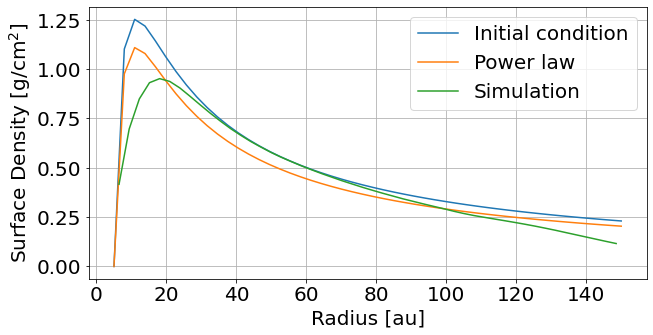

In [25]:
# --- Plotting Surface Density radial profiles ---
fig, ax = plt.subplots(figsize=(10,5))
units_s = {'position': 'au', 'surface_density': 'g/cm^2'}
#time0 = sim.properties['time'].to('year')[0]
#time = snap.properties['time'].to('year')
#label0 = f'{time0.m:.0f}'
#label = f'{time.m:.0f}'

#profile0.plot('radius', 'surface_density', units=units, label=label0, ax=ax)
plt.plot(r_, profile_an_sim0, label='Initial condition')
plt.plot(r_, profile_an_sim, label='Power law')
profile.plot('radius', 'surface_density', units=units_s, label='Simulation', ax=ax)
#plt.axhline(0.328674435, ls='--')
#plt.axhline(Sigma_prof[r_>=100][0].m, ls='--')
#plt.ylim(0.2, 0.4)

ax.tick_params(labelsize=20)
ax.set_ylabel('Surface Density [g/cm${}^2$]', fontsize=20)
ax.set_xlabel('Radius [au]', fontsize=20)
ax.legend(loc='best', fontsize=20)
ax.grid()
#fig.savefig(dir + 'Profilo_density.png')

## Perturbations calculated with average background field

### Taken from Thomas Hilder's code https://github.com/TomHilder/wakeflow

Interpolating Phantom results onto a regularly spaced polar grid...


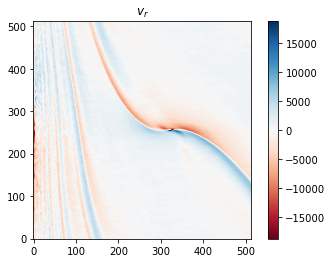

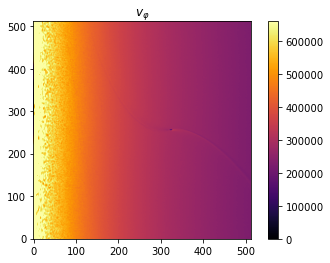

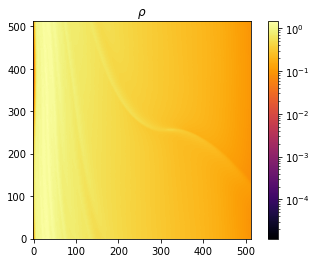

In [26]:
# --- Creation of grids ---

PLOTS = True
M_STAR = 1
R_INNER = 5
R_OUTER = 155 # Slightly larger radius to avoid border effects during interpolation
R_REF = 100
R_CRIT = 75
P_INDEX = 1

M_SOL   = c.M_sun.cgs.value
M_JUP   = c.M_jup.cgs.value
G_CONST = c.G.cgs.value
AU      = c.au.cgs.value

# read in midplane arrays, in cgs units
a_ = R_OUTER*plonk.units('au')
extent_ = (-a_,a_,-a_,a_)
vr_sph = interpolate(snap = snap, quantity='velocity_radial_cylindrical', interp='slice', extent=extent_).to('cm/s').magnitude
vphi_sph = interpolate(snap = snap, quantity='azimuthal_velocity', interp='slice', extent=extent_).to('cm/s').magnitude
rho_sph = interpolate(snap = snap, quantity='density', interp='projection', extent=extent_).to('g/cm^2').m

# get phantom grid
PH_GRID_LENGTH = vr_sph.shape[0]
x_ph = np.linspace(-R_OUTER, R_OUTER, PH_GRID_LENGTH)
y_ph = np.linspace(-R_OUTER, R_OUTER, PH_GRID_LENGTH)
X_ph, Y_ph = np.meshgrid(x_ph, y_ph)

print("Interpolating Phantom results onto a regularly spaced polar grid...")

# interpolate over phantom grid
vr_interp   = RectBivariateSpline(y_ph, x_ph, vr_sph)
vphi_interp = RectBivariateSpline(y_ph, x_ph, vphi_sph)
rho_interp  = RectBivariateSpline(y_ph, x_ph, rho_sph)

# regularly spaced cylindrical grid
r_reg   = np.linspace(R_INNER, R_OUTER, PH_GRID_LENGTH)
phi_reg = np.linspace(-np.pi,    np.pi, PH_GRID_LENGTH)
R_reg, PHI_reg = np.meshgrid(r_reg, phi_reg)

# convert regularly space cylindrical grid to cartesian irregular grid
X_reg = R_reg * np.cos(PHI_reg)
Y_reg = R_reg * np.sin(PHI_reg)

# evalutate interpolation on polar grid
vr_polar   = vr_interp.ev  (Y_reg, X_reg)
vphi_polar = vphi_interp.ev(Y_reg, X_reg)
rho_polar  = rho_interp.ev (Y_reg, X_reg)

# test plots
if PLOTS:
    plt.title(r"$v_r$")
    plt.imshow(vr_polar, cmap="RdBu", vmin=-0.6*min(abs(vr_polar.min()),abs(vr_polar.max())), vmax=0.6*min(abs(vr_polar.min()),abs(vr_polar.max())), origin="lower")
    plt.colorbar()
    plt.show()
    plt.title(r"$v_\varphi$")
    plt.imshow(vphi_polar, cmap="inferno", vmin=0, vmax=0.5*abs(vphi_polar.max()), origin="lower")
    plt.colorbar()
    plt.show()
    plt.title(r"$\rho$")
    plt.imshow(rho_polar, cmap="inferno", norm=cl.LogNorm(vmin=np.abs(rho_polar).min(), vmax=rho_polar.max()), origin="lower")
    plt.colorbar()
    plt.show()


Subtracting azimuthally averaged density and rotation...


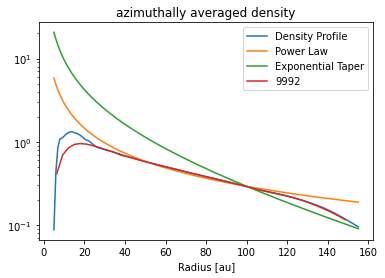

In [27]:
# === background density and Keplerian rotation subtraction === #

print("Subtracting azimuthally averaged density and rotation...")

AZ_WIDTH = 1

# calculate the mean with a lambda
w = AZ_WIDTH / 2
f_ = lambda r : rho_polar[(R_reg >= r-w) & (R_reg < r+w) & ((PHI_reg < -np.pi/4) | (PHI_reg > np.pi/4))].mean()
r  = np.linspace(R_INNER, R_OUTER, num=int(R_OUTER))
mean = np.vectorize(f_)(r)
mean_interp_func = interp.interp1d(r, mean, kind='linear')

# density at reference radius
RHO_REF = f_(R_REF)
RHO_REF_TAPER = RHO_REF / np.exp(-(R_REF / R_CRIT)**(2-P_INDEX))

rho_power_law = RHO_REF * (r / R_REF)**(-P_INDEX)
rho_taper     = RHO_REF_TAPER * (r / R_REF)**(-P_INDEX) * np.exp(-(r / R_CRIT)**(2-P_INDEX))

# test plot
if PLOTS:
    fig,ax=plt.subplots()
    ax.plot(r, mean, label="Density Profile")
    ax.plot(r, rho_power_law, label="Power Law")
    ax.plot(r, rho_taper, label="Exponential Taper")
    profile.plot('radius', 'surface_density', units=units_s, label=label, ax=ax)
    ax.set_title("azimuthally averaged density")
    ax.set_yscale('log')
    ax.legend(loc="best")
    plt.show()

# subtract azimuthal average
averaged = mean_interp_func(R_reg)
rho_pert = (rho_polar - averaged) / averaged

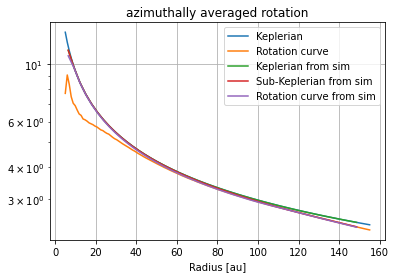

In [29]:
# calculate Keplerian velocities for plotting
v_keplerian = np.sqrt(G_CONST * M_STAR * M_SOL / (r * AU))

# calculate the mean with a lambda
w = AZ_WIDTH/2
f_ = lambda r : vphi_polar[(R_reg >= r-w) & (R_reg < r+w) & ((PHI_reg < -np.pi/4) | (PHI_reg > np.pi/4))].mean()
r  = np.linspace(R_INNER, R_OUTER, num=int(R_OUTER))
mean = np.vectorize(f_)(r)
mean_interp_func = interp.interp1d(r, mean, kind='linear')

# test plot
if PLOTS:
    fig,ax=plt.subplots()
    plt.plot(r, v_keplerian/1e5, label="Keplerian")
    #plt.plot(r, v_keplerian*(1 - 1.5 * (hrp)**2 * (r/r_planet.m)**0.5)**0.5, label="sub-Keplerian")
    ax.plot(r, mean/1e5, label="Rotation curve")
    units_v = {'position': 'au', 'vK': 'km/s'}
    profile.plot('radius', 'vK', units=units_v, label='Keplerian from sim', ax=ax)
    profile.plot('radius', 'vK_corrected', units=units_v, label='Sub-Keplerian from sim', ax=ax)
    profile.plot('radius', 'azimuthal_velocity', units=units_v, label='Rotation curve from sim', ax=ax)
    ax.set_title("azimuthally averaged rotation")
    ax.set_yscale("log")
    #plt.xlim(100,120)
    #plt.ylim(2.8,3.2)
    ax.legend(loc="best")
    #plt.loglog()
    plt.grid()
    plt.show()

# subtract azimuthal average
averaged = mean_interp_func(R_reg)
vphi_pert = (vphi_polar - averaged)
vphi_pert /= 1e5

# radial velocities don't need subtraction
vr_pert = cp.copy(vr_polar)
vr_pert /= 1e5

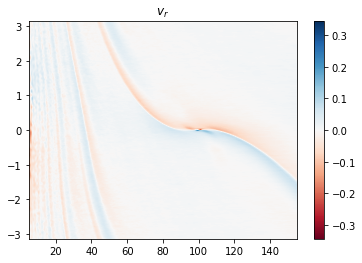

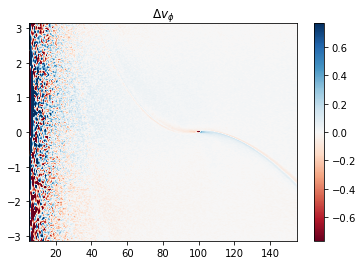

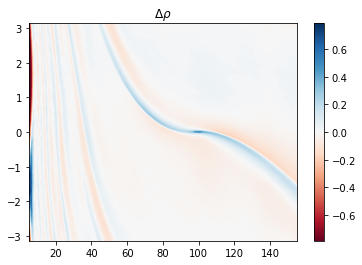

In [30]:
    plt.title(r"$v_r$")
    plt.imshow(vr_pert, cmap="RdBu", vmin=-1.1*min(abs(vr_pert.min()),abs(vr_pert.max())), 
               vmax=1.1*min(abs(vr_pert.min()),abs(vr_pert.max())), origin="lower", 
               extent = (R_INNER, R_OUTER, -np.pi, np.pi), aspect = 'auto')
    plt.colorbar()
    plt.show()
    plt.title(r"$\Delta v_\phi$")
    R_EXC = 50
    plt.imshow(vphi_pert, cmap="RdBu", vmin=-min(abs(vphi_pert[R_reg>R_EXC].min()),abs(vphi_pert[R_reg>R_EXC].max())), 
        vmax=min(abs(vphi_pert[R_reg>R_EXC].min()),abs(vphi_pert[R_reg>R_EXC].max())), origin="lower", 
               extent = (R_INNER, R_OUTER, -np.pi, np.pi), aspect = 'auto')
    plt.colorbar()
    plt.show()
    plt.title(r"$\Delta \rho$")
    plt.imshow(rho_pert, cmap="RdBu", vmin=-1*min(abs(rho_pert.min()),abs(rho_pert.max())), 
               vmax=1*min(abs(rho_pert.min()),abs(rho_pert.max())), origin="lower", 
               extent = (R_INNER, R_OUTER, -np.pi, np.pi), aspect = 'auto')
    plt.colorbar()
    plt.show()

In [31]:
# --- Interpolate back to cartesian grid ---
# interpolate over cylindrical grid
vr_interp_back   = RectBivariateSpline(phi_reg, r_reg, vr_pert)
vphi_interp_back = RectBivariateSpline(phi_reg, r_reg, vphi_pert)
rho_interp_back  = RectBivariateSpline(phi_reg, r_reg, rho_pert)

# convert grid
R_sph = np.sqrt(X_ph**2 + Y_ph**2)
PHI_sph = np.arctan2(Y_ph, X_ph)

# evaluate interpolation on cartesian grid
vr_sph_pert   = vr_interp_back.ev  (PHI_sph, R_sph)
vphi_sph_pert = vphi_interp_back.ev(PHI_sph, R_sph)
rho_sph_pert  = rho_interp_back.ev (PHI_sph, R_sph)

# cutting the disc
vr_sph_pert[np.sqrt(X_ph**2 + Y_ph**2)>155] = 0 
vphi_sph_pert[np.sqrt(X_ph**2 + Y_ph**2)>155] = 0 
rho_sph_pert[np.sqrt(X_ph**2 + Y_ph**2)>155] = 0 

# Comparison between Simulations and Semi-analytical model

In [32]:
# --- Function for plots (adapted from Bollati) ---
def make_cp(field, bar_label = None, title = None, saveas = None, WithChannels = None, vz_field = None, bar_label_size = None,
            ax = None, cax = None, vmin = None, vmax = None, xlim = None, ylim = None, ticks = None, n_ticks=7, nocb=None):

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    #fig.set_size_inches(8,8)

    # set contour levels
    if vmax == None:
        max_field = round(field.max(),2)
        d = 2*max_field/1000
        levels = np.arange(-max_field*(1+0.1),max_field*(1+0.1),d)
    else:
        d = (vmax-vmin)/1000
        levels = np.arange(vmin*(1+0.1),vmax*(1+0.1),d)

    contour = ax.contourf(s.X,s.Y,field, levels = levels ,cmap='RdBu',zorder=0, vmin = vmin, vmax=vmax)

    # colorbar
    #cax = fig.add_axes([ax.get_position(original=True).x1,ax.get_position(original=True).y0,0.05*ax.get_position(original=True).width,ax.get_position(original=True).height])
    if vmax == None:
        cb = fig.colorbar(contour, ticks=[-max_field,-max_field/2,0,max_field/2,max_field],
                      ax=ax, cax=cax)
    elif ticks == None:
        cb = fig.colorbar(contour, ticks=[np.round(vmin,2),np.round(vmin/2,2),0,np.round(vmax/2,2),np.round(vmax,2)],
                      ax=ax, cax=cax)
    else:
        cb = fig.colorbar(contour, ticks=ticks,
                      ax=ax, cax=cax)
    if bar_label != None:
        if bar_label_size != None:
            cb.set_label(bar_label, fontsize = bar_label_size)
        else:
            cb.set_label(bar_label)
    cb.ax.locator_params(nbins=5)
    cb.ax.tick_params(labelsize=20)
    if nocb == True:
        cb.remove()

    # plot disc edge and star and wake
    #ax.plot(s.disc_edge[:,0],s.disc_edge[:,1],color='k')
    #ax.scatter(0,0,label="star",color='gold',zorder = +2,s = 80, marker=(5, 1))
    if s.wake:
        if WithChannels == None:
            ax.plot(s.R[0]*np.cos(f.phi_wake(s.R[0])), s.R[0]*np.sin(f.phi_wake(s.R[0])), c='m', lw = 1)
    
    # plot channel maps
    if WithChannels == True:

        channel_maps = f.get_channel_maps(vz_field)

        # set channel maps levels
        levelsch = [s.vchs[0] - s.delta_vch]
        Nvch = len(s.vchs)
        levelsch += [0.5*(s.vchs[i]+s.vchs[i+1]) for i in range(0,Nvch-1)]
        levelsch += [s.vchs[-1] + s.delta_vch]
        levelsch = np.array(levelsch)

        # plot channel maps
        if Nvch > 1:
            chmps = ax.contourf(s.X, s.Y, channel_maps, levels = levelsch, cmap = 'RdBu', zorder = 2, vmin=vmin, vmax=vmax)
        else:
            chmps =  ax.contourf(s.X, s.Y, channel_maps, levels = levelsch, colors = 'orange', zorder = 2)
        del chmps.collections[4:4]
        cm = ax.contour(s.X, s.Y, channel_maps, levels = levelsch, colors='black', linewidths = 1 ,zorder = 3)

        # legend
        #proxy = [plt.Rectangle((0,0),1,1,fc=pc.get_facecolor()[0]) for pc in chmps.collections]
        #leg2 = plt.legend(proxy, [str(s.vchs[i]) for i in range(len(s.vchs))],loc="lower left",title="$v_{ch}$ [km/s]:")

        # disable limited range when plotting channel maps
        ax.axis('equal')
        s.xrange = 0
        s.yrange = 0

    if title != None:
        ax.title(title)


    # set range
    if np.ndim(s.xrange) == 0 and np.ndim(s.yrange) == 0:
        ax.axis('equal')
    else:
        if np.ndim(s.xrange)>0:
            ax.set_xlim(s.xrange)

        if np.ndim(s.yrange)>0:
            ax.set_ylim(s.yrange)
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
    ax.set_aspect('equal', adjustable = 'box')

    ax.locator_params(nbins=n_ticks) # number of ticks per axis
    ax.set_xlabel("$x$   [au]", fontsize=20)
    ax.set_ylabel("$y$   [au]", fontsize=20)

    if ax is None:
        if s.show:
            plt.show()
        else:
            plt.savefig(saveas)
    else:
        return ax

In [33]:
# --- Loading analytical fields ---
vr = np.load(dir + '/vr.npy')
vphi = np.load(dir + '/vphi.npy')
vK = f.create_Keplerian_velocity_field()
density_pert = np.load(dir + '/density_pert.npy')

In [34]:
# --- Calculating maximum of fields ---
rho_max = np.max(np.round(density_pert, 2))
vr_max = np.max(np.abs(np.round(vr, 2)))
vphi_max = np.max(np.abs(np.round(vphi-vK, 2)))
# needed for plots

### Global Wake

Text(0, 0.5, '')

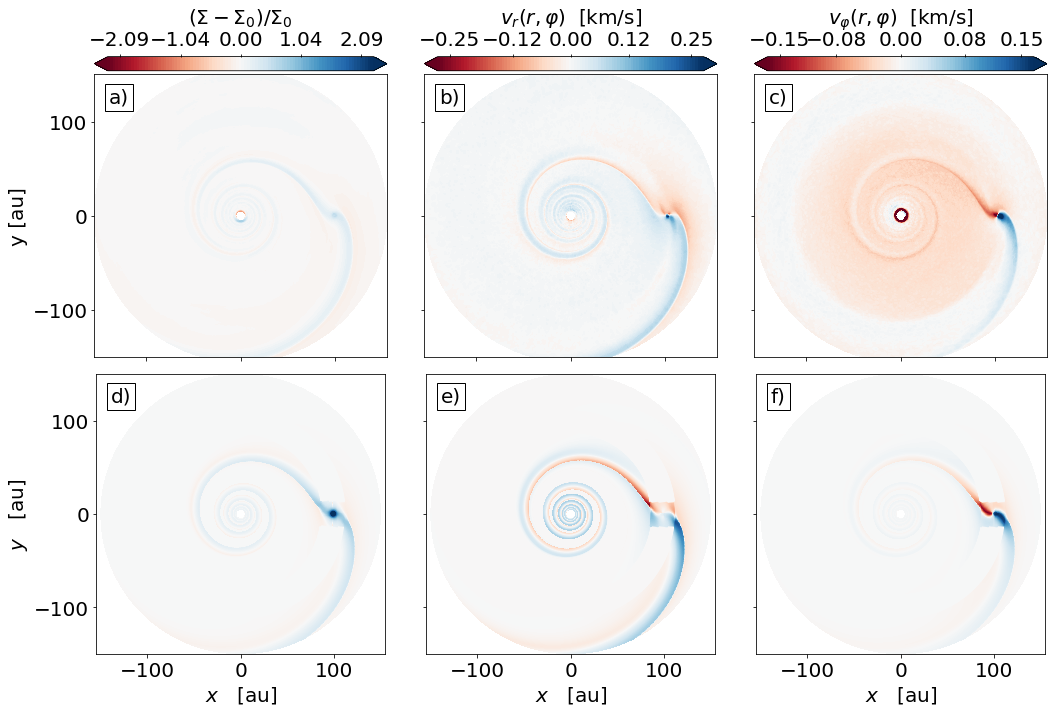

In [35]:
# --- Interpolating fields ---
vr_toplot = interpolate(snap = snap, quantity='velocity_radial_cylindrical', interp='slice', extent=extent, num_pixels=[512,512]).to('km/s').m
vphi_toplot = interpolate(snap = snap, quantity='azimuthal_velocity_pert', interp='slice', extent=extent, num_pixels=[512,512]).to('km/s').m

vphi_interp_toplot = RectBivariateSpline(y_ph, x_ph, vphi_toplot)
vphi_toplot_polar = vphi_interp_toplot.ev(Y_reg, X_reg)

vr_interp_toplot = RectBivariateSpline(y_ph, x_ph, vr_toplot)
vr_toplot_polar = vr_interp_toplot.ev(Y_reg, X_reg)

# --- Plotting ---
fig, axes = plt.subplots(2,3, figsize = (15,10), sharey = 'row', sharex = 'col', tight_layout = True)

divider = make_axes_locatable(axes[0,0])
cax = divider.append_axes('top', size='5%', pad=0.05)
max_field = rho_max
levels = np.linspace(-1.1*max_field, 1.1*max_field, 100)
im = axes[0,0].contourf(X_reg, Y_reg, rho_pert, levels = levels, cmap ="RdBu", extend='both')
axes[0,0].set_xlim([-150,150])
axes[0,0].set_ylim([-150,150])
axes[0,0].set_ylabel('y [au]', fontsize=20)
axes[0,0].set_yticks([-100, 0, 100])
axes[0,0].set_aspect('equal', adjustable = 'box')
axes[0,0].text(0.05,0.90, r'a)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[0,0].transAxes)
cb=plt.colorbar(im, cax = cax, label=r'$ (\Sigma - \Sigma _0)/\Sigma _0$', orientation = 'horizontal',
                ticks=[-np.round(max_field,2),-np.round(max_field/2,2),0,np.round(max_field/2,2),np.round(max_field,2)])
cb.ax.tick_params(labelsize=20)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.set_xlabel(r'$ (\Sigma - \Sigma _0)/\Sigma _0$', fontsize=20, labelpad=7)
cb.ax.xaxis.set_label_position('top')
axes[0,0].tick_params(labelsize=20)

divider = make_axes_locatable(axes[0,1])
cax = divider.append_axes('top', size='5%', pad=0.05)
max_field = vr_max
levels = np.linspace(-1.1*max_field, 1.1*max_field, 100)
im = axes[0,1].contourf(X_reg, Y_reg, vr_toplot_polar, levels = levels, cmap ="RdBu", extend='both')
#axes[0,1].set_xlim(limits[0:2])
#axes[0,1].set_ylim(limits[2:4])
axes[0,1].set_aspect('equal', adjustable = 'box')
axes[0,1].text(0.05,0.90, r'b)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[0,1].transAxes)
cb=plt.colorbar(im, cax = cax, label=r'$v_r(r,\varphi)$  [km/s]', orientation = 'horizontal',
                ticks=[-np.round(max_field,2),-np.round(max_field/2,2),0,np.round(max_field/2,2),np.round(max_field,2)])
cb.ax.tick_params(labelsize=20)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.set_xlabel(r'$v_r(r,\varphi)$  [km/s]', fontsize=20, labelpad=7)
cb.ax.xaxis.set_label_position('top')
axes[0,1].tick_params(labelsize=20)

divider = make_axes_locatable(axes[0,2])
cax = divider.append_axes('top', size='5%', pad=0.05)
max_field = vphi_max
levels = np.linspace(-1.1*max_field, 1.1*max_field, 100)
im = axes[0,2].contourf(X_reg, Y_reg, vphi_toplot_polar, levels = levels, cmap ="RdBu", extend='both')
#axes[0,2].set_xlim(limits[0:2])
#axes[0,2].set_ylim(limits[2:4])
axes[0,2].set_aspect('equal', adjustable = 'box')
axes[0,2].text(0.05,0.90, r'c)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[0,2].transAxes)
cb=plt.colorbar(im, cax = cax, label=r'$v_{\varphi}(r,\varphi)$  [km/s]', orientation = 'horizontal',
                ticks=[-np.round(max_field,2),-np.round(max_field/2,2),0,np.round(max_field/2,2),np.round(max_field,2)])
cb.ax.tick_params(labelsize=20)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.set_xlabel(r'$v_{\varphi}(r,\varphi)$  [km/s]', fontsize=20, labelpad=7)
cb.ax.xaxis.set_label_position('top')
axes[0,2].tick_params(labelsize=20)

divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes('top', size='5%', pad=0.1)
make_cp(density_pert, bar_label = r'$ (\Sigma - \Sigma _0)/\Sigma _0$', ax = axes[1,0], bar_label_size="20",
        cax=cax, vmin = -rho_max, vmax = rho_max, n_ticks=3, nocb=True)
axes[1,0].tick_params(labelsize=20)
axes[1,0].text(0.05,0.90, r'd)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[1,0].transAxes)

divider = make_axes_locatable(axes[1,1])
cax = divider.append_axes('top', size='5%', pad=0.1)
make_cp(vr, bar_label=r'$v_r(r,\varphi)$  [km/s]', ax = axes[1,1], bar_label_size="20",
        cax=cax, vmin = -vr_max, vmax = vr_max, n_ticks=3, nocb=True)
axes[1,1].tick_params(labelsize=20)
axes[1,1].text(0.05,0.90, r'e)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[1,1].transAxes)
axes[1,1].set_ylabel('')

divider = make_axes_locatable(axes[1,2])
cax = divider.append_axes('top', size='5%', pad=0.1)
make_cp(vphi- (-s.cw * vK), bar_label=r'$v_{\varphi}(r,\varphi)$  [km/s]', ax = axes[1,2], bar_label_size="20",
        cax=cax, vmin = -vphi_max, vmax = vphi_max, n_ticks=3, nocb=True)
axes[1,2].tick_params(labelsize=20)
axes[1,2].text(0.05,0.90, r'f)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[1,2].transAxes)
axes[1,2].set_ylabel('')

#fig.savefig(dir + 'confronto.png')

### Zoom In

Text(0, 0.5, '')

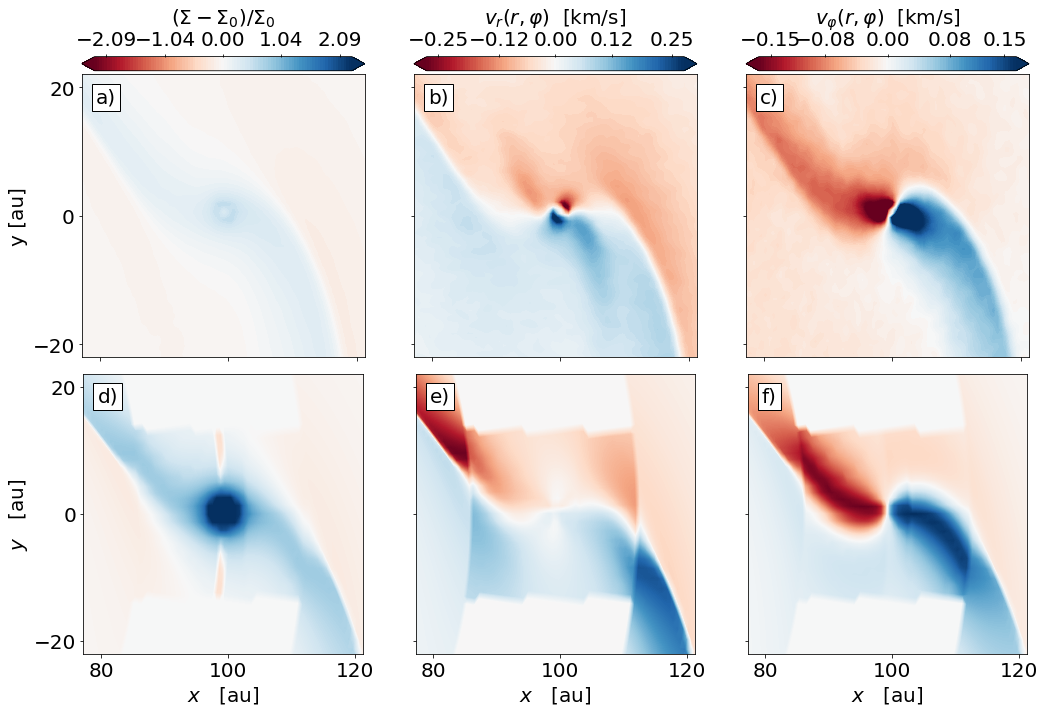

In [36]:
# --- Interpolating fields ---
vr_toplot = interpolate(snap = snap, quantity='velocity_radial_cylindrical', interp='slice', extent=extent, num_pixels=[500,500]).to('km/s').m
vphi_toplot = interpolate(snap = snap, quantity='azimuthal_velocity_pert', interp='slice', extent=extent, num_pixels=[500,500]).to('km/s').m

# --- Plotting ---
fig, axes = plt.subplots(2,3, figsize = (15,10), sharey = 'row', sharex = 'col', tight_layout = True)

divider = make_axes_locatable(axes[0,0])
cax = divider.append_axes('top', size='5%', pad=0.05)
max_field = rho_max
levels = np.linspace(-1.1*max_field, 1.1*max_field, 100)
im = axes[0,0].contourf(X_reg, Y_reg, rho_pert, levels = levels, cmap ="RdBu", extend='both')
axes[0,0].set_xlim(limits[0:2])
axes[0,0].set_ylim(limits[2:4])
axes[0,0].set_ylabel('y [au]', fontsize=20)
axes[0,0].set_yticks([-20, 0, 20])
axes[0,0].set_aspect('equal', adjustable = 'box')
axes[0,0].text(0.05,0.90, r'a)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[0,0].transAxes)
cb=plt.colorbar(im, cax = cax, label=r'$ (\Sigma - \Sigma _0)/\Sigma _0$', orientation = 'horizontal',
                ticks=[-np.round(max_field,2),-np.round(max_field/2,2),0,np.round(max_field/2,2),np.round(max_field,2)])
cb.ax.tick_params(labelsize=20)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.set_xlabel(r'$ (\Sigma - \Sigma _0)/\Sigma _0$', fontsize=20, labelpad=7)
cb.ax.xaxis.set_label_position('top')
axes[0,0].tick_params(labelsize=20)

divider = make_axes_locatable(axes[0,1])
cax = divider.append_axes('top', size='5%', pad=0.05)
max_field = vr_max
levels = np.linspace(-1.1*max_field, 1.1*max_field, 100)
im = axes[0,1].contourf(s.x, s.y, vr_toplot, levels = levels, cmap ="RdBu", extend='both')
axes[0,1].set_xlim(limits[0:2])
axes[0,1].set_ylim(limits[2:4])
axes[0,1].set_aspect('equal', adjustable = 'box')
axes[0,1].text(0.05,0.90, r'b)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[0,1].transAxes)
cb=plt.colorbar(im, cax = cax, label=r'$v_r(r,\varphi)$  [km/s]', orientation = 'horizontal',
                ticks=[-np.round(max_field,2),-np.round(max_field/2,2),0,np.round(max_field/2,2),np.round(max_field,2)])
cb.ax.tick_params(labelsize=20)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.set_xlabel(r'$v_r(r,\varphi)$  [km/s]', fontsize=20, labelpad=7)
cb.ax.xaxis.set_label_position('top')
axes[0,1].tick_params(labelsize=20)

divider = make_axes_locatable(axes[0,2])
cax = divider.append_axes('top', size='5%', pad=0.05)
max_field = vphi_max
levels = np.linspace(-1.1*max_field, 1.1*max_field, 100)
im = axes[0,2].contourf(s.x, s.y, vphi_toplot, levels = levels, cmap ="RdBu", extend='both')
axes[0,2].set_xlim(limits[0:2])
axes[0,2].set_ylim(limits[2:4])
axes[0,2].set_aspect('equal', adjustable = 'box')
axes[0,2].text(0.05,0.90, r'c)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[0,2].transAxes)
cb=plt.colorbar(im, cax = cax, label=r'$v_{\varphi}(r,\varphi)$  [km/s]', orientation = 'horizontal',
                ticks=[-np.round(max_field,2),-np.round(max_field/2,2),0,np.round(max_field/2,2),np.round(max_field,2)])
cb.ax.tick_params(labelsize=20)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.set_xlabel(r'$v_{\varphi}(r,\varphi)$  [km/s]', fontsize=20, labelpad=7)
cb.ax.xaxis.set_label_position('top')
axes[0,2].tick_params(labelsize=20)

divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes('top', size='5%', pad=0.1)
make_cp(density_pert, bar_label = r'$ (\Sigma - \Sigma _0)/\Sigma _0$', ax = axes[1,0], bar_label_size="20",
        xlim = limits[0:2], ylim =limits[2:4], cax=cax, vmin = -rho_max, vmax = rho_max, n_ticks=3, nocb=True)
axes[1,0].tick_params(labelsize=20)
axes[1,0].text(0.05,0.90, r'd)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[1,0].transAxes)

divider = make_axes_locatable(axes[1,1])
cax = divider.append_axes('top', size='5%', pad=0.1)
make_cp(vr, bar_label=r'$v_r(r,\varphi)$  [km/s]', ax = axes[1,1], bar_label_size="20",
        xlim = limits[0:2], ylim =limits[2:4], cax=cax, vmin = -vr_max, vmax = vr_max, n_ticks=3, nocb=True)
axes[1,1].tick_params(labelsize=20)
axes[1,1].text(0.05,0.90, r'e)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[1,1].transAxes)
axes[1,1].set_ylabel('')

divider = make_axes_locatable(axes[1,2])
cax = divider.append_axes('top', size='5%', pad=0.1)
make_cp(vphi- (-s.cw * vK), bar_label=r'$v_{\varphi}(r,\varphi)$  [km/s]', ax = axes[1,2], bar_label_size="20",
        xlim = limits[0:2], ylim =limits[2:4], cax=cax, vmin = -vphi_max, vmax = vphi_max, n_ticks=3, nocb=True)
axes[1,2].tick_params(labelsize=20)
axes[1,2].text(0.05,0.90, r'f)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=axes[1,2].transAxes)
axes[1,2].set_ylabel('')

#fig.savefig(dir + 'confronto_zoom.png')

## Profiles

### Eta

In [37]:
# --- Functions from Bollati ---
def phi_wake(rr): 
    #rr = r / r_planet.magnitude
    return  np.sign(rr-1)*(1/hrp)*( rr**(s.q-0.5)/(s.q-0.5) - rr**(s.q + 1)/(s.q+1)-3/((2*s.q-1)*(s.q+1)) )

def _Eta(r,phi): 

    coeff = 1.5/hrp
    phi_w = mod2pi(phi_wake(r))
    deltaphi = phi - phi_w

    if deltaphi > np.pi:
        deltaphi = deltaphi -2*np.pi
    elif deltaphi < -np.pi:
        deltaphi = deltaphi + 2*np.pi

    return coeff*deltaphi

def mod2pi(phi):
    if phi>=0:
        return phi%(2*np.pi)
    else:
        if np.abs(phi)<np.pi*2:
            return phi+2*np.pi
        else:
            phi = -phi
            resto = phi%(2*np.pi)
        return -resto+2*np.pi

### t

In [38]:
# --- Functions from Bollati ---
def t_integrand(x):
    rho = 5*s.q + s.p
    w = rho/2 - 11/4
    return np.abs( 1 - x**(1.5) )**(1.5) * x**w

def t_integral(up):
    return  quad(t_integrand,1,up)[0]

def _t(r):
    module_integral = np.abs( t_integral(r) )
    coeff = 3*hrp**(-5/2)/(2**(5/4))
    return coeff*module_integral

### Auxiliary functions

In [39]:
# --- Functions from Bollati ---
def Lambda_fu(rr):       # Eq. (28) Bollati et al. 2021

    coeff = 2**0.75*s.csp*hrp**(-0.5)/(s.indad+1)
    term1 = np.abs( (rr)**(-1.5)-1 )**0.5
    term2 = (rr)**(0.5*(s.p+s.q-1))
    return coeff*term1*term2


def Lambda_fv(rr):      # Eq. (29) Bollati et al. 2021

    coeff = 2**0.75*s.csp*hrp**0.5/(s.indad+1)
    term1 = np.abs( (rr)**(-1.5)-1 )**(-0.5)
    term2 = (rr)**(0.5*(s.p-s.q-3))
    return coeff*term1*term2

def _g(rr):

    coeff = 2**0.25*hrp**0.5
    term1 = (rr)**(0.5*(1-s.p-3*s.q))
    term2 = np.abs( (rr)**(-1.5)-1 )**(-0.5)
    return coeff*term1*term2

### Interpolation

In [43]:
# --- t extrema ---
t0_outer = _t(1 + s.l*s.x_match/s.Rp)
t0_inner = _t(1 - s.l*s.x_match/s.Rp)
t_edge = _t(155/r_planet.m)
print(r't_{0,inner} = ' + str(t0_inner))
print(r't_{0,outer} = ' + str(t0_outer))
print(r't_{edge} = ' + str(t_edge))        

t_{0,inner} = 2.1605671510543027
t_{0,outer} = 1.7013591904580796
t_{edge} = 46.63220983215562


Table with the maximum value of t in the inner disc, chosen between either 150 or the maximum value reached in the analytics

| h/r-Mmp | 0.50    | 0.75   | 1.00  | 1.25  | 2 | 3 |
|:------|:--:|:--:|:--:|:--:|:--:|:--:|
| 0.075 | 150 | 150 | 150 | 136.8880512660785 | -- | 68.76356172540744 |
| 0.100 | 150 | 150 | 150 | 150 | -- | 79.62328326235816 |
| 0.125 | 150 | 150 | 150 | 150 | -- | 85.97369085032548 |
| 0.150 | 150 | 150 | 150 | 150 | 129.8940427933225 | 90.15405344977181 |

In [44]:
# --- (t,eta) grid creation ---
t_outer = np.linspace(t0_outer, t_edge, 500)
eta = np.linspace(-25, 25, 500)
t_grid_outer, eta_grid_outer = np.meshgrid(t_outer, eta, indexing = 'ij')
t_inner = np.linspace(t0_inner, 150, 500) 
t_grid_inner, eta_grid_inner = np.meshgrid(t_inner, eta, indexing = 'ij')

In [45]:
# --- Calculating (R, Phi) values associated to (t,eta) grid ---

# If they exist, load them (much faster)
if os.path.exists(dir + '/R_grid_inner.npy') and os.path.exists(dir + '/Phi_grid_inner.npy'):
    R_grid_inner = np.load(dir + 'R_grid_inner.npy')
    Phi_grid_inner = np.load(dir + 'Phi_grid_inner.npy')
# If not, calculate them (much slower)
else:
    R_grid_inner = np.zeros(np.shape(t_grid_inner))
    Phi_grid_inner = np.zeros(np.shape(t_grid_inner))

    for i in range(len(t_grid_inner[1])):
        def invert_t(x):
            return _t(x) - t_grid_inner.T[0][i]
        R_grid.T[0][i] = fsolve(invert_t, x0 = 0.9)
        # In the inner disc the algorithm does not always converge. Change the initial condition to make it work
        if np.isclose(invert_t(R_grid_inner.T[0][i]), [0.0]) == False:
            R_grid_inner.T[0][i] = fsolve(invert_t, x0 = 0.7)
        if np.isclose(invert_t(R_grid_inner.T[0][i]), [0.0]) == False:
            R_grid_inner.T[0][i] = fsolve(invert_t, x0 = 0.5)
        if np.isclose(invert_t(R_grid_inner.T[0][i]), [0.0]) == False:
            R_grid_inner.T[0][i] = fsolve(invert_t, x0 = 0.3)
        for j in range(len(t_grid_inner)):
            def invert_eta(x, rr):
                return  _Eta(rr, x)-eta_grid_inner[i][j]
            Phi_grid_inner[i][j] = mod2pi(fsolve(invert_eta, x0=2, args=R_grid_inner.T[0][i]))
            R_grid_inner.T[j][i] = R_grid_inner.T[0][i]
    np.save(dir + 'R_grid_inner.npy', R_grid_inner)
    np.save(dir + 'Phi_grid_inner.npy', Phi_grid_inner)

if os.path.exists(dir + '/R_grid_outer.npy') and os.path.exists(dir + '/Phi_grid_outer.npy'):
    R_grid_outer = np.load(dir + 'R_grid_outer.npy')
    Phi_grid_outer = np.load(dir + 'Phi_grid_outer.npy')
else:
    R_grid_outer = np.zeros(np.shape(t_grid_outer))
    Phi_grid_outer = np.zeros(np.shape(t_grid_outer))

    for i in range(len(t_grid_outer[1])):
        def invert_t(x):
            return _t(x) - t_grid_outer.T[0][i]
        R_grid_outer.T[0][i] = fsolve(invert_t, x0 = 1.1)
        for j in range(len(t_grid_outer)):
            def invert_eta(x, rr):
                return  _Eta(rr, x)-eta_grid_outer[i][j]
            Phi_grid_outer[i][j] = mod2pi(fsolve(invert_eta, x0=2, args=R_grid_outer.T[0][i]))
            R_grid_outer.T[j][i] = R_grid_outer.T[0][i]
    np.save(dir + 'R_grid_outer.npy', R_grid_outer)
    np.save(dir + 'Phi_grid_outer.npy', Phi_grid_outer)

In [47]:
# --- Trallalla check ---
skip = True # Set it to false if you performed the calculation above

if skip == True:
    print('Already checked')
else:
    trallalla = 0
    for i in range(len(t_grid_inner[1])):
        if np.isclose(_t(R_grid_inner.T[0][i]), t_grid_inner.T[0][i]) == False:
            print('problem')
        else:
            trallalla +=1
    if trallalla == len(t_grid_inner[1]):
        print('I did it!')

    trallalla = 0
    for i in range(len(t_grid_outer[1])):
        if np.isclose(_t(R_grid_outer.T[0][i]), t_grid_outer.T[0][i]) == False:
            print('problem')
        else:
            trallalla +=1
    if trallalla == len(t_grid_outer[1]):
        print('I did it again!')

    trallalla = 0
    for i in range(len(t_grid_inner[1])):
        for j in range(len(t_grid_inner)):
            if np.isclose(_Eta(R_grid_inner.T[0][i], Phi_grid_inner[i][j]), eta_grid_inner[i][j]) == False:
                print('problem')
            else:
                trallalla +=1
    if trallalla == len(t_grid_inner[1])*len(t_grid_inner):
        print('And again!')

    trallalla = 0
    for i in range(len(t_grid_outer[1])):
        for j in range(len(t_grid_outer)):
            if np.isclose(_Eta(R_grid_outer.T[0][i], Phi_grid_outer[i][j]), eta_grid_outer[i][j]) == False:
                print('problem')
            else:
                trallalla +=1
    if trallalla == len(t_grid_outer[1])*len(t_grid_outer):
        print('Coding streak!')

Already checked


In [51]:
# --- Cartesian grid associated to (t,eta) grid ---
x_grid_outer = R_grid_outer * np.cos(Phi_grid_outer)*r_planet.magnitude
y_grid_outer = R_grid_outer * np.sin(Phi_grid_outer)*r_planet.magnitude

x_grid_inner = R_grid_inner * np.cos(Phi_grid_inner)*r_planet.magnitude
y_grid_inner = R_grid_inner * np.sin(Phi_grid_inner)*r_planet.magnitude

# --- Sph fields ---
v_r_sph = interpolate(snap = snap, quantity='velocity_radial_cylindrical', interp='slice', extent=extent, num_pixels = [1000, 1000]).to("km/s").magnitude #limits*plonk.units('au')
v_phi_sph = interpolate(snap = snap, quantity='azimuthal_velocity_pert', interp='slice', extent=extent, num_pixels = [1000, 1000]).to("km/s").magnitude #limits*plonk.units('au')
v_phi_sph_alt = interpolate(snap = snap, quantity='azimuthal_velocity_pert_alt', interp='slice', extent=extent, num_pixels = [1000, 1000]).to("km/s").magnitude #limits*plonk.units('au')
v_r_sph_inner = interpolate(snap = snap, quantity='velocity_radial_cylindrical', interp='slice', extent=extent_in, num_pixels = [2000, 2000]).to("km/s").magnitude #limits*plonk.units('au')
v_phi_sph_inner = interpolate(snap = snap, quantity='azimuthal_velocity_pert', interp='slice', extent=extent_in, num_pixels = [2000, 2000]).to("km/s").magnitude #limits*plonk.units('au')
x_sph = np.linspace(-150, 150, 1000)
y_sph = np.linspace(-150, 150, 1000)
x_sph_inner = np.linspace(-100, 100, 2000)
y_sph_inner = np.linspace(-100, 100, 2000)

### Inner Disc

In [52]:
# --- Interpolating radial velocity --- 
vr_inner_int = np.zeros(np.shape(x_grid_inner))

for i in range(len(x_grid_inner)):
    for j in range(len(x_grid_inner)):
        idx_x = np.argmax(x_sph_inner>x_grid_inner[j][i])
        idx_y = np.argmax(y_sph_inner>y_grid_inner[j][i])
        if idx_x == 0:
            idx_x += 1
        if idx_y == 0:
            idx_y +=1
        x_grid_int = np.array([x_sph_inner[idx_x-1], x_sph_inner[idx_x]])
        y_grid_int = np.array([y_sph_inner[idx_y-1], y_sph_inner[idx_y]])
        vr_grid_int = np.array([
                    [v_r_sph_inner[idx_y-1,idx_x-1], v_r_sph_inner[idx_y-1,idx_x]],
                    [v_r_sph_inner[idx_y,idx_x-1], v_r_sph_inner[idx_y,idx_x]]
                    ])
        inter = RectBivariateSpline(y_grid_int, x_grid_int, vr_grid_int, kx=1, ky=1)
        vr_inner_int[j][i] = inter(y_grid_inner[j][i], x_grid_inner[j][i])

In [53]:
# --- Interpolating azimuthal velocity ---
vphi_inner_int = np.zeros(np.shape(x_grid_inner))

for i in range(len(x_grid_inner)):
    for j in range(len(x_grid_inner)):
        idx_x = np.argmax(x_sph_inner>x_grid_inner[j][i])
        idx_y = np.argmax(y_sph_inner>y_grid_inner[j][i])
        if idx_x == 0:
            idx_x += 1
        if idx_y == 0:
            idx_y +=1
        x_grid_int = np.array([x_sph_inner[idx_x-1], x_sph_inner[idx_x]])
        y_grid_int = np.array([y_sph_inner[idx_y-1], y_sph_inner[idx_y]])
        vphi_grid_int = np.array([
                    [v_phi_sph_inner[idx_y-1,idx_x-1], v_phi_sph_inner[idx_y-1,idx_x]],
                    [v_phi_sph_inner[idx_y,idx_x-1], v_phi_sph_inner[idx_y,idx_x]]
                    ])
        inter = RectBivariateSpline(y_grid_int, x_grid_int, vphi_grid_int, kx=1, ky=1)
        vphi_inner_int[j][i] = inter(y_grid_inner[j][i], x_grid_inner[j][i])

In [54]:
# --- Interpolating surface density ---
rho_inner_int = np.zeros(np.shape(x_grid_inner))

for i in range(len(x_grid_inner)):
    for j in range(len(x_grid_inner)):
        idx_x = np.argmax(x_ph>x_grid_inner[j][i])
        idx_y = np.argmax(y_ph>y_grid_inner[j][i])
        if idx_x == 0:
            idx_x += 1
        if idx_y == 0:
            idx_y +=1
        x_grid_int = np.array([x_ph[idx_x-1], x_ph[idx_x]])
        y_grid_int = np.array([y_ph[idx_y-1], y_ph[idx_y]])
        rho_grid_int = np.array([
                    [rho_sph_pert[idx_y-1,idx_x-1], rho_sph_pert[idx_y-1,idx_x]],
                    [rho_sph_pert[idx_y,idx_x-1], rho_sph_pert[idx_y,idx_x]]
                    ])
        inter = RectBivariateSpline(y_grid_int, x_grid_int, rho_grid_int, kx=1, ky=1)
        rho_inner_int[j][i] = inter(y_grid_inner[j][i], x_grid_inner[j][i])

### Outer Disc

In [55]:
# --- Using true radial extent of disc --- 
idx_r = np.argmax(R_grid_outer.T[0]>150/r_planet.magnitude)
print(idx_r)

x_grid_outer = x_grid_outer[:idx_r]
t_outer = t_outer[:idx_r]

403


In [56]:
# --- Interpolating radial velocity --- 
vr_outer_int = np.zeros(np.shape(x_grid_outer[:idx_r]))
print(np.shape(vr_outer_int))

for i in range(len(vr_outer_int[0])):
    for j in range(len(vr_outer_int)):
        idx_x = np.argmax(x_sph>x_grid_outer[j][i])
        idx_y = np.argmax(y_sph>y_grid_outer[j][i])
        if idx_x == 0:
            idx_x += 1
        if idx_y == 0:
            idx_y +=1
        x_grid_int = np.array([x_sph[idx_x-1], x_sph[idx_x]])
        y_grid_int = np.array([y_sph[idx_y-1], y_sph[idx_y]])
        vr_grid_int = np.array([
                    [v_r_sph[idx_y-1,idx_x-1], v_r_sph[idx_y-1,idx_x]],
                    [v_r_sph[idx_y,idx_x-1], v_r_sph[idx_y,idx_x]]
                    ])
        inter = RectBivariateSpline(y_grid_int, x_grid_int, vr_grid_int, kx=1, ky=1)
        vr_outer_int[j][i] = inter(y_grid_outer[j][i], x_grid_outer[j][i])

(403, 500)


In [57]:
# --- Interpolating azimuthal velocity ---
vphi_outer_int = np.zeros(np.shape(x_grid_outer)) # Using v_phi - v_K * corr
print(np.shape(vphi_outer_int))

for i in range(len(vphi_outer_int[0])):
    for j in range(len(vphi_outer_int)):
        idx_x = np.argmax(x_sph>x_grid_outer[j][i])
        idx_y = np.argmax(y_sph>y_grid_outer[j][i])
        if idx_x == 0:
            idx_x += 1
        if idx_y == 0:
            idx_y +=1
        x_grid_int = np.array([x_sph[idx_x-1], x_sph[idx_x]])
        y_grid_int = np.array([y_sph[idx_y-1], y_sph[idx_y]])
        vphi_grid_int = np.array([
                    [v_phi_sph[idx_y-1,idx_x-1], v_phi_sph[idx_y-1,idx_x]],
                    [v_phi_sph[idx_y,idx_x-1], v_phi_sph[idx_y,idx_x]]
                    ])
        inter = RectBivariateSpline(y_grid_int, x_grid_int, vphi_grid_int, kx=1, ky=1)
        vphi_outer_int[j][i] = inter(y_grid_outer[j][i], x_grid_outer[j][i])

(403, 500)


In [58]:
# --- Interpolating azimuthal velocity ---
vphi_outer_int_alt = np.zeros(np.shape(x_grid_outer)) # Using v_phi - v_K
print(np.shape(vphi_outer_int_alt))

for i in range(len(vphi_outer_int_alt[0])):
    for j in range(len(vphi_outer_int_alt)):
        idx_x = np.argmax(x_sph>x_grid_outer[j][i])
        idx_y = np.argmax(y_sph>y_grid_outer[j][i])
        if idx_x == 0:
            idx_x += 1
        if idx_y == 0:
            idx_y +=1
        x_grid_int = np.array([x_sph[idx_x-1], x_sph[idx_x]])
        y_grid_int = np.array([y_sph[idx_y-1], y_sph[idx_y]])
        vphi_grid_int_alt = np.array([
                    [v_phi_sph_alt[idx_y-1,idx_x-1], v_phi_sph_alt[idx_y-1,idx_x]],
                    [v_phi_sph_alt[idx_y,idx_x-1], v_phi_sph_alt[idx_y,idx_x]]
                    ])
        inter = RectBivariateSpline(y_grid_int, x_grid_int, vphi_grid_int_alt, kx=1, ky=1)
        vphi_outer_int_alt[j][i] = inter(y_grid_outer[j][i], x_grid_outer[j][i])

(403, 500)


In [59]:
# --- Interpolating surface density ---
rho_outer_int = np.zeros(np.shape(x_grid_outer))
print(np.shape(vphi_outer_int))

for i in range(len(rho_outer_int[0])):
    for j in range(len(rho_outer_int)):
        idx_x = np.argmax(x_ph>x_grid_outer[j][i])
        idx_y = np.argmax(y_ph>y_grid_outer[j][i])
        if idx_x == 0:
            idx_x += 1
        if idx_y == 0:
            idx_y +=1
        x_grid_int = np.array([x_ph[idx_x-1], x_ph[idx_x]])
        y_grid_int = np.array([y_ph[idx_y-1], y_ph[idx_y]])
        rho_grid_int = np.array([
                    [rho_sph_pert[idx_y-1,idx_x-1], rho_sph_pert[idx_y-1,idx_x]],
                    [rho_sph_pert[idx_y,idx_x-1], rho_sph_pert[idx_y,idx_x]]
                    ])
        inter = RectBivariateSpline(y_grid_int, x_grid_int, rho_grid_int, kx=1, ky=1)
        rho_outer_int[j][i] = inter(y_grid_outer[j][i], x_grid_outer[j][i])

(403, 500)


## Analytics

In [60]:
# --- Reading Analytics ---
t_a_outer = np.load(dir + 't_outer.npy')
t_a_outer += t0_outer
eta_a_outer = np.load(dir + 'eta_outer.npy')
chi_a_outer = np.load(dir + 'chi_outer.npy')

t_a_inner = np.load(dir + 't_inner.npy')
t_a_inner += t0_inner
eta_a_inner = np.load(dir + 'eta_inner.npy')
chi_a_inner = np.load(dir + 'chi_inner.npy')

In [61]:
# --- Adapting to simulations ---
t_mask_outer = t_a_outer <= np.max(t_outer)
t_a_outer = t_a_outer[t_mask_outer]
chi_a_outer = chi_a_outer[:,t_mask_outer]

t_mask_inner = t_a_inner <= np.max(t_inner)
t_a_inner = t_a_inner[t_mask_inner]
chi_a_inner = chi_a_inner[:,t_mask_inner]

### Outer Disc

In [62]:
# --- Calculating R values associated to t values ---
if os.path.exists(dir + '/R_inverse_a_outer.npy'):
    R_inverse_a_outer = np.load(dir + 'R_inverse_a_outer.npy')
else:
    R_inverse_a_outer = np.zeros(np.shape(t_a_outer))

    for i in range(len(t_a_outer)):
            def invert_t(x):
                return _t(x) - t_a_outer[i]
            R_inverse_a_outer[i] = fsolve(invert_t, x0 = 1.1)
    np.save(dir + 'R_inverse_a_outer.npy', R_inverse_a_outer)

In [63]:
# --- Trallalla check ---
skip = True # Set it to false if you performed the calculation above

if skip == True:
    print('Already checked')
else:
    trallalla = 0
    for i in range(len(t_a_outer)):
        if np.isclose(_t(R_inverse_a_outer[i]), t_a_outer[i]) == False:
            print('problem')
        else:
            trallalla +=1
    if trallalla == len(t_a_outer):
        print('I did it!')

Already checked


In [64]:
# --- Calculating fields from Chi ---
if os.path.exists(dir + '/vr_a_outer.npy') and os.path.exists(dir + '/vphi_a_outer.npy') and os.path.exists(dir + '/dsigma_a_outer.npy'):
    vr_a_outer = np.load(dir + 'vr_a_outer.npy')
    vphi_a_outer = np.load(dir + 'vphi_a_outer.npy')
    dsigma_a_outer = np.load(dir + 'dsigma_a_outer.npy')
else:
    vr_a_outer = np.zeros(np.shape(chi_a_outer))
    vphi_a_outer = np.zeros(np.shape(chi_a_outer))
    dsigma_a_outer = np.zeros(np.shape(chi_a_outer))

    for i in range(np.shape(chi_a_outer)[0]):
        for j in range(np.shape(chi_a_outer)[1]):
            rr = R_inverse_a_outer[j]
            Lfu = Lambda_fu(rr)
            Lfv = Lambda_fv(rr)
            g = _g(rr)
            vr_a_outer[i][j] = np.sign(rr-1) * Lfu * chi_a_outer[i,j]
            vphi_a_outer[i][j] = np.sign(rr-1) * Lfv * chi_a_outer[i,j]
            dsigma_a_outer[i][j] = 2/((1+s.indad)*g) * chi_a_outer[i,j]   
    np.save(dir + 'vr_a_outer.npy', vr_a_outer)
    np.save(dir + 'vphi_a_outer.npy', vphi_a_outer)
    np.save(dir + 'dsigma_a_outer.npy', dsigma_a_outer)

### Inner Disc

In [65]:
# --- Calculating R values associated to t values ---
if os.path.exists(dir + '/R_inverse_a_inner.npy'):
    R_inverse_a_inner = np.load(dir + 'R_inverse_a_inner.npy')
else:
    R_inverse_a_inner = np.zeros(np.shape(t_a_inner))

    for i in range(len(t_a_inner)):
            def invert_t(x):
                return _t(x) - t_a_inner[i]
            R_inverse_a_inner[i] = fsolve(invert_t, x0 = 0.9)
            if np.isclose(invert_t(R_inverse_a_inner[i]), [0.0]) == False:
                R_inverse_a_inner[i] = fsolve(invert_t, x0 = 0.7)
            if np.isclose(invert_t(R_inverse_a_inner[i]), [0.0]) == False:
                R_inverse_a_inner[i] = fsolve(invert_t, x0 = 0.5)
    np.save(dir + 'R_inverse_a_inner.npy', R_inverse_a_inner)

In [66]:
# --- Trallalla check ---
skip = True # Set it to false if you performed the calculation above

if skip == True:
    print('Already checked')
else:
    trallalla = 0
    for i in range(len(t_a_inner)):
        if np.isclose(_t(R_inverse_a_inner[i]), t_a_inner[i]) == False:
            print('problem')
        else:
            trallalla +=1
    if trallalla == len(t_a_inner):
        print('I did it!')

Already checked


In [67]:
# --- Calculating fields from Chi ---
if os.path.exists(dir + '/vr_a_inner.npy') and os.path.exists(dir + '/vphi_a_inner.npy') and os.path.exists(dir + '/dsigma_a_inner.npy'):
    vr_a_inner = np.load(dir + 'vr_a_inner.npy')
    vphi_a_inner = np.load(dir + 'vphi_a_inner.npy')
    dsigma_a_inner = np.load(dir + 'dsigma_a_inner.npy')
else:
    vr_a_inner = np.zeros(np.shape(chi_a_inner))
    vphi_a_inner = np.zeros(np.shape(chi_a_inner))
    dsigma_a_inner = np.zeros(np.shape(chi_a_inner))

    for i in range(np.shape(chi_a_inner)[0]):
        for j in range(np.shape(chi_a_inner)[1]):
            rr = R_inverse_a_inner[j]
            Lfu = Lambda_fu(rr)
            Lfv = Lambda_fv(rr)
            g = _g(rr)
            vr_a_inner[i][j] = np.sign(rr-1) * Lfu * chi_a_inner[i,j]
            vphi_a_inner[i][j] = np.sign(rr-1) * Lfv * chi_a_inner[i,j] 
            dsigma_a_inner[i][j] = 2/((1+s.indad)*g) * chi_a_inner[i,j]
    np.save(dir + 'vr_a_inner.npy', vr_a_inner)
    np.save(dir + 'vphi_a_inner.npy', vphi_a_inner)
    np.save(dir + 'dsigma_a_inner.npy', dsigma_a_inner)

## Plotting

### Inner Disc

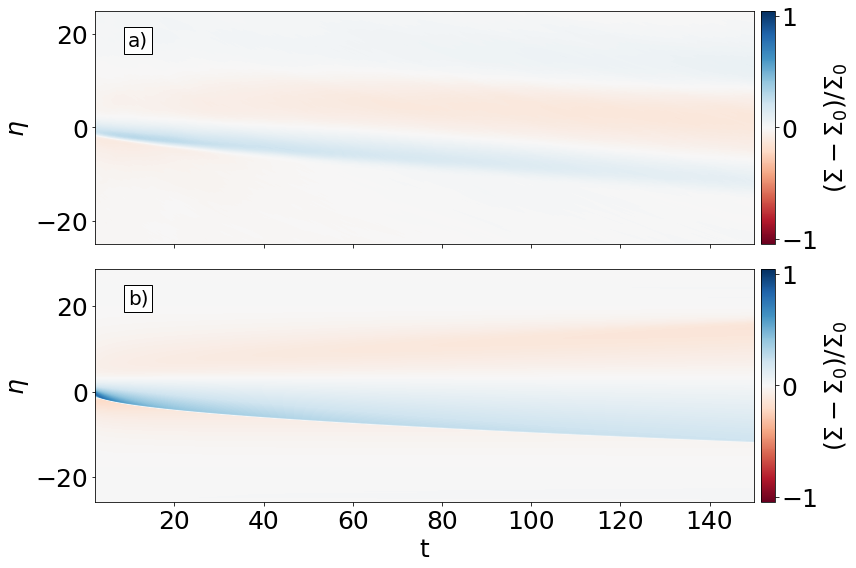

In [68]:
# --- Plotting density in (t,eta) space ---
fig, ax = plt.subplots(2, 1, figsize = (12, 8), sharex=True, tight_layout = True)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.1)
im1 = ax[0].imshow(rho_inner_int.T, origin = 'lower', aspect = 'auto', vmax = rho_max/2, vmin = -rho_max/2, cmap = 'RdBu',
                   extent = (np.min(t_inner), np.max(t_inner), np.min(eta), np.max(eta)))
#ax[0].set_xlabel('t', fontsize=20)
ax[0].tick_params(labelsize=25)
ax[0].set_ylabel(r'$\eta$', fontsize=25)
ax[0].text(0.05,0.85, r'a)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[0].transAxes)
#ax[0].set_title(r'Analytic $ (\Sigma - \Sigma _0)/\Sigma _0$ inner disc', fontsize=20)
cb = plt.colorbar(im1, label = r'$ (\Sigma - \Sigma _0)/\Sigma _0$', cax = cax)
cb.ax.tick_params(labelsize=25)
cb.ax.set_ylabel(r'$ (\Sigma - \Sigma _0)/\Sigma _0$', fontsize=25)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='2%', pad=0.1)
im2 = ax[1].imshow(dsigma_a_inner, origin = 'lower', aspect = 'auto', vmax = rho_max/2, vmin = -rho_max/2, cmap = 'RdBu',
                   extent = (np.min(t_a_inner), np.round(np.max(t_a_inner)), np.min(eta_a_inner), np.max(eta_a_inner)))
ax[1].set_xlabel('t', fontsize=25)
ax[1].tick_params(labelsize=25)
ax[1].set_ylabel(r'$\eta$', fontsize=25)
ax[1].text(0.05,0.85, r'b)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[1].transAxes)
#ax[1].set_title(r'Analytic $v_\varphi$ inner disc', fontsize=20)
cb = plt.colorbar(im2, label = r'$ (\Sigma - \Sigma _0)/\Sigma _0$', cax = cax)
cb.ax.tick_params(labelsize=25)
cb.ax.set_ylabel(r'$ (\Sigma - \Sigma _0)/\Sigma _0$', fontsize=25)

#plt.savefig(dir + "comp_as_dsigma_in.png", bbox_inches = 'tight');

Text(0, 0.5, '$v_r$ [km/s]')

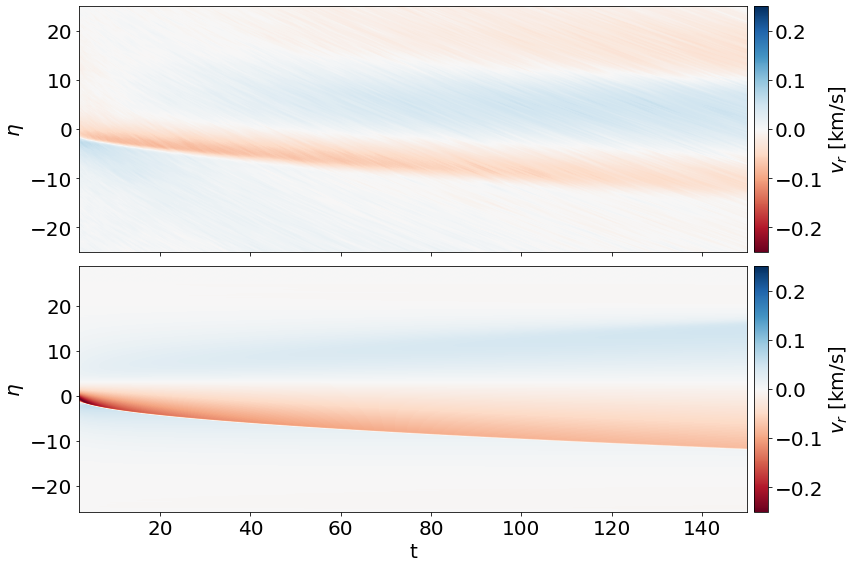

In [70]:
# --- Plotting radial velocity in (t,eta) space ---
fig, ax = plt.subplots(2, 1, figsize = (12, 8), sharex=True, tight_layout = True)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.1)
im1 = ax[0].imshow(vr_inner_int.T, origin = 'lower', aspect = 'auto', vmax = vr_max, vmin = -vr_max, cmap = 'RdBu',
                   extent = (np.min(t_inner), np.max(t_inner), np.min(eta), np.max(eta)))
#ax[0].set_xlabel('t', fontsize = 20)
ax[0].tick_params(labelsize=20)
ax[0].set_ylabel(r'$\eta$', fontsize = 20)
#ax[0].set_title(r'Simulated $v_r$ inner disc')
cb = plt.colorbar(im1, label = r'$v_r$ [km/s]', cax = cax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r'$v_r$ [km/s]', fontsize=20)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='2%', pad=0.1)
im2 = ax[1].imshow(vr_a_inner, origin = 'lower', aspect = 'auto', vmax = vr_max, vmin = -vr_max, cmap = 'RdBu',
                   extent = (np.min(t_a_inner), np.round(np.max(t_a_inner)), np.min(eta_a_inner), np.max(eta_a_inner)))
ax[1].tick_params(labelsize=20)
ax[1].set_xlabel('t', fontsize = 20)
ax[1].set_ylabel(r'$\eta$', fontsize = 20)
#ax[1].set_title(r'Analytic $v_r$ inner disc')
cb = plt.colorbar(im2, label = r'$v_r$ [km/s]', cax = cax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r'$v_r$ [km/s]', fontsize=20)

#plt.savefig(dir + "comp_as_vr_in.png", bbox_inches = 'tight');

Text(0, 0.5, '$v_\\varphi$ [km/s]')

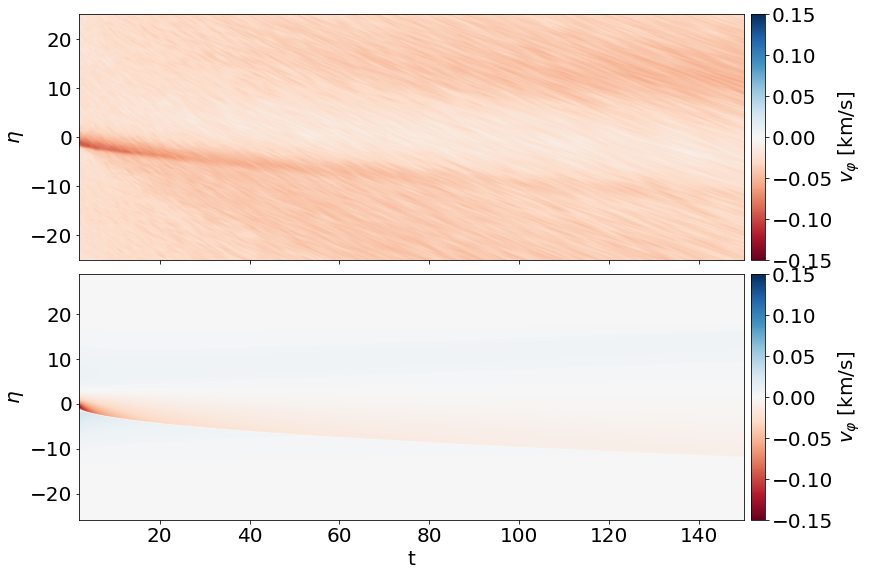

In [72]:
# --- Plotting azimuthal velocity in (t,eta) space ---
fig, ax = plt.subplots(2, 1, figsize = (12, 8), sharex=True, tight_layout = True)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.1)
im1 = ax[0].imshow(vphi_inner_int.T, origin = 'lower', aspect = 'auto', vmax = vphi_max, vmin = -vphi_max, cmap = 'RdBu',
                   extent = (np.min(t_inner), np.max(t_inner), np.min(eta), np.max(eta)))
#ax[0].set_xlabel('t', fontsize=20)
ax[0].tick_params(labelsize=20)
ax[0].set_ylabel(r'$\eta$', fontsize=20)
#ax[0].set_title(r'Simulated $v_\varphi$ inner disc', fontsize=20)
cb = plt.colorbar(im1, label = r'$v_\varphi$ [km/s]', cax = cax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r'$v_\varphi$ [km/s]', fontsize=20)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='2%', pad=0.1)
im2 = ax[1].imshow(vphi_a_inner, origin = 'lower', aspect = 'auto', vmax = vphi_max, vmin = -vphi_max, cmap = 'RdBu',
                   extent = (np.min(t_a_inner), np.round(np.max(t_a_inner)), np.min(eta_a_inner), np.max(eta_a_inner)))
ax[1].set_xlabel('t', fontsize=20)
ax[1].tick_params(labelsize=20)
ax[1].set_ylabel(r'$\eta$', fontsize=20)
#ax[1].set_title(r'Analytic $v_\varphi$ inner disc', fontsize=20)
cb = plt.colorbar(im2, label = r'$v_\varphi$ [km/s]', cax = cax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r'$v_\varphi$ [km/s]', fontsize=20)

#plt.savefig(dir + "comp_as_vphi_in.png", bbox_inches = 'tight');

### Outer Disc

Text(0, 0.5, '$ (\\Sigma - \\Sigma _0)/\\Sigma _0$')

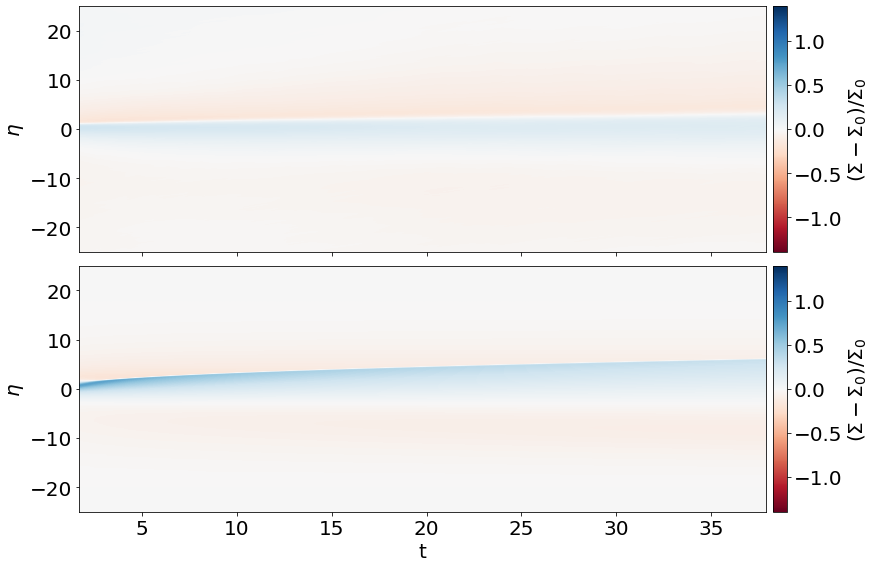

In [77]:
# --- Plotting density in (t,eta) space ---
fig, ax = plt.subplots(2, 1, figsize = (12, 8), sharex=True, tight_layout = True)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.1)
im1 = ax[0].imshow(rho_outer_int.T, origin = 'lower', aspect = 'auto', vmax = rho_max/1.5, vmin = -rho_max/1.5, cmap = 'RdBu',
                   extent = (np.min(t_outer), np.max(t_outer), np.min(eta), np.max(eta)))
#ax[0].set_xlabel('t', fontsize=20)
ax[0].tick_params(labelsize=20)
ax[0].set_ylabel(r'$\eta$', fontsize=20)
#ax[0].set_title(r'Analytic $ (\Sigma - \Sigma _0)/\Sigma _0$ outer disc', fontsize=20)
cb = plt.colorbar(im1, label = r'$ (\Sigma - \Sigma _0)/\Sigma _0$', cax = cax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r'$ (\Sigma - \Sigma _0)/\Sigma _0$', fontsize=20)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='2%', pad=0.1)
im2 = ax[1].imshow(dsigma_a_outer, origin = 'lower', aspect = 'auto', vmax = rho_max/1.5, vmin = -rho_max/1.5, cmap = 'RdBu',
                   extent = (np.min(t_a_outer), np.max(t_a_outer), np.min(eta_a_outer), np.max(eta_a_outer)))
ax[1].set_xlabel('t', fontsize=20)
ax[1].tick_params(labelsize=20)
ax[1].set_ylabel(r'$\eta$', fontsize=20)
#ax[1].set_title(r'Analytic $v_\varphi$ outer disc', fontsize=20)
cb = plt.colorbar(im2, label = r'$ (\Sigma - \Sigma _0)/\Sigma _0$', cax = cax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r'$ (\Sigma - \Sigma _0)/\Sigma _0$', fontsize=20)
#plt.savefig(dir + "comp_as_dsigma_out.png", bbox_inches = 'tight');

Text(0, 0.5, '$v_r$ [km/s]')

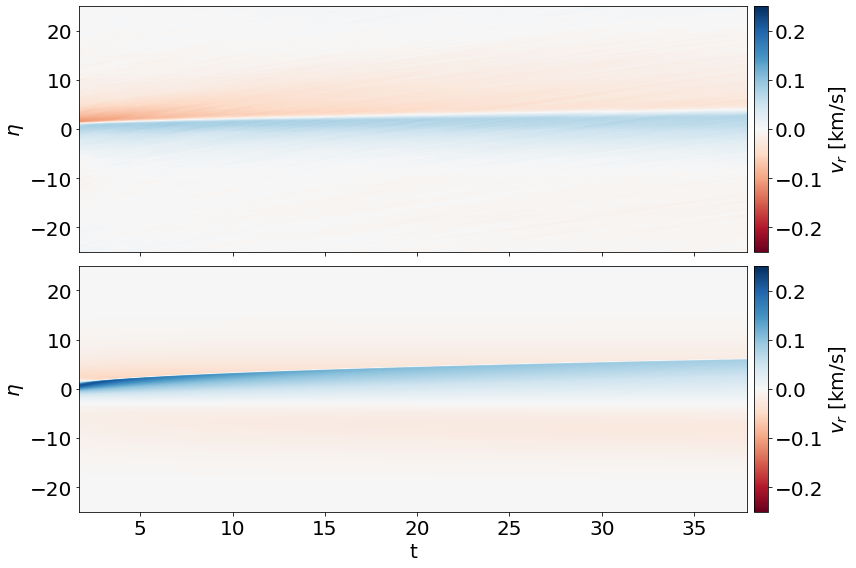

In [78]:
# --- Plotting radial velocity in (t,eta) space ---
fig, ax = plt.subplots(2, 1, figsize = (12, 8), sharex=True, tight_layout = True)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.1)
im1 = ax[0].imshow(vr_outer_int.T, origin = 'lower', aspect = 'auto', vmax = vr_max, vmin = -vr_max, cmap = 'RdBu',
                   extent = (np.min(t_outer), np.max(t_outer), np.min(eta), np.max(eta)))
#ax[0].set_xlabel('t', fontsize = 20)
ax[0].tick_params(labelsize=20)
ax[0].set_ylabel(r'$\eta$', fontsize = 20)
#ax[0].set_title(r'Simulated $v_r$ outer disc')
cb = plt.colorbar(im1, label = r'$v_r$ [km/s]', cax = cax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r'$v_r$ [km/s]', fontsize=20)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='2%', pad=0.1)
im2 = ax[1].imshow(vr_a_outer, origin = 'lower', aspect = 'auto', vmax = vr_max, vmin = -vr_max, cmap = 'RdBu',
                   extent = (np.min(t_a_outer), np.max(t_a_outer), np.min(eta_a_outer), np.max(eta_a_outer)))
ax[1].tick_params(labelsize=20)
ax[1].set_xlabel('t', fontsize = 20)
ax[1].set_ylabel(r'$\eta$', fontsize = 20)
#ax[1].set_title(r'Analytic $v_r$ outer disc')
cb = plt.colorbar(im2, label = r'$v_r$ [km/s]', cax = cax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r'$v_r$ [km/s]', fontsize=20)

#plt.savefig(dir + "comp_as_vr_out.png", bbox_inches = 'tight');

Text(0, 0.5, '$v_\\varphi$ [km/s]')

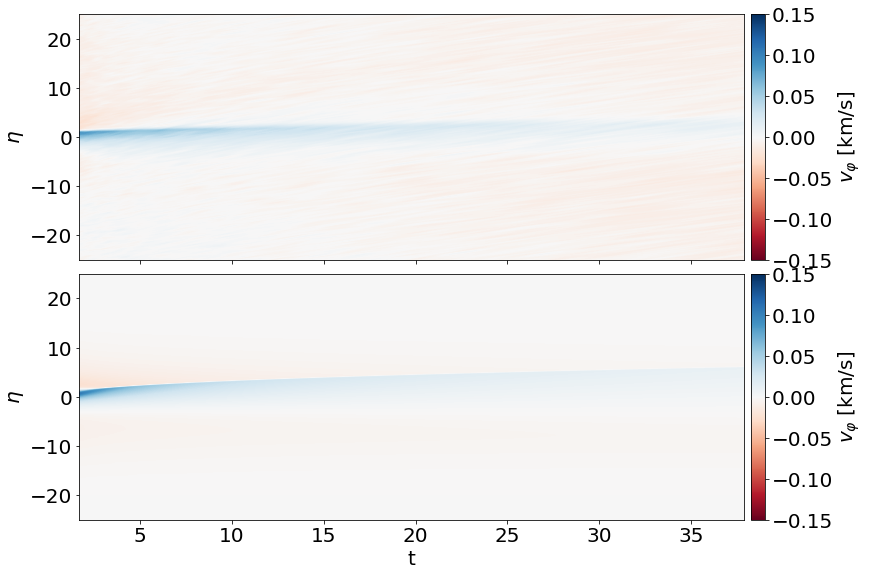

In [79]:
# --- Plotting azimuthal velocity in (t,eta) space ---
fig, ax = plt.subplots(2, 1, figsize = (12, 8), sharex=True, tight_layout = True)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.1)
im1 = ax[0].imshow(vphi_outer_int.T, origin = 'lower', aspect = 'auto', vmax = vphi_max, vmin = -vphi_max, cmap = 'RdBu',
                   extent = (np.min(t_outer), np.max(t_outer), np.min(eta), np.max(eta)))
#ax[0].set_xlabel('t', fontsize=20)
ax[0].tick_params(labelsize=20)
ax[0].set_ylabel(r'$\eta$', fontsize=20)
#ax[0].set_title(r'Simulated $v_\varphi$ outer disc', fontsize=20)
cb = plt.colorbar(im1, label = r'$v_\varphi$ [km/s]', cax = cax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r'$v_\varphi$ [km/s]', fontsize=20)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='2%', pad=0.1)
im2 = ax[1].imshow(vphi_a_outer, origin = 'lower', aspect = 'auto', vmax = vphi_max, vmin = -vphi_max, cmap = 'RdBu',
                   extent = (np.min(t_a_outer), np.max(t_a_outer), np.min(eta_a_outer), np.max(eta_a_outer)))
ax[1].set_xlabel('t', fontsize=20)
ax[1].tick_params(labelsize=20)
ax[1].set_ylabel(r'$\eta$', fontsize=20)
#ax[1].set_title(r'Analytic $v_\varphi$ outer disc', fontsize=20)
cb = plt.colorbar(im2, label = r'$v_\varphi$ [km/s]', cax = cax)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r'$v_\varphi$ [km/s]', fontsize=20)

#plt.savefig(dir + "comp_as_vphi_out.png", bbox_inches = 'tight');

## Profiles (finally)

In [80]:
# --- Magic tricks for beautiful color bars ---
import cmastro
%run C:\\Users\\faisa\\Anaconda3\\lib\\site-packages\\cmastro\\cm.py

# --- Function for geometrical distance between planet and wake ---    
def distance(rr):
    R = rr*r_planet.m
    Phi_wake = phi_wake(rr)
    planet_position = np.array([r_planet.m, 0])
    profile_position = np.array([R * np.cos(Phi_wake), R * np.sin(Phi_wake)])
    return np.round(np.linalg.norm(profile_position-planet_position))

### Outer Disc

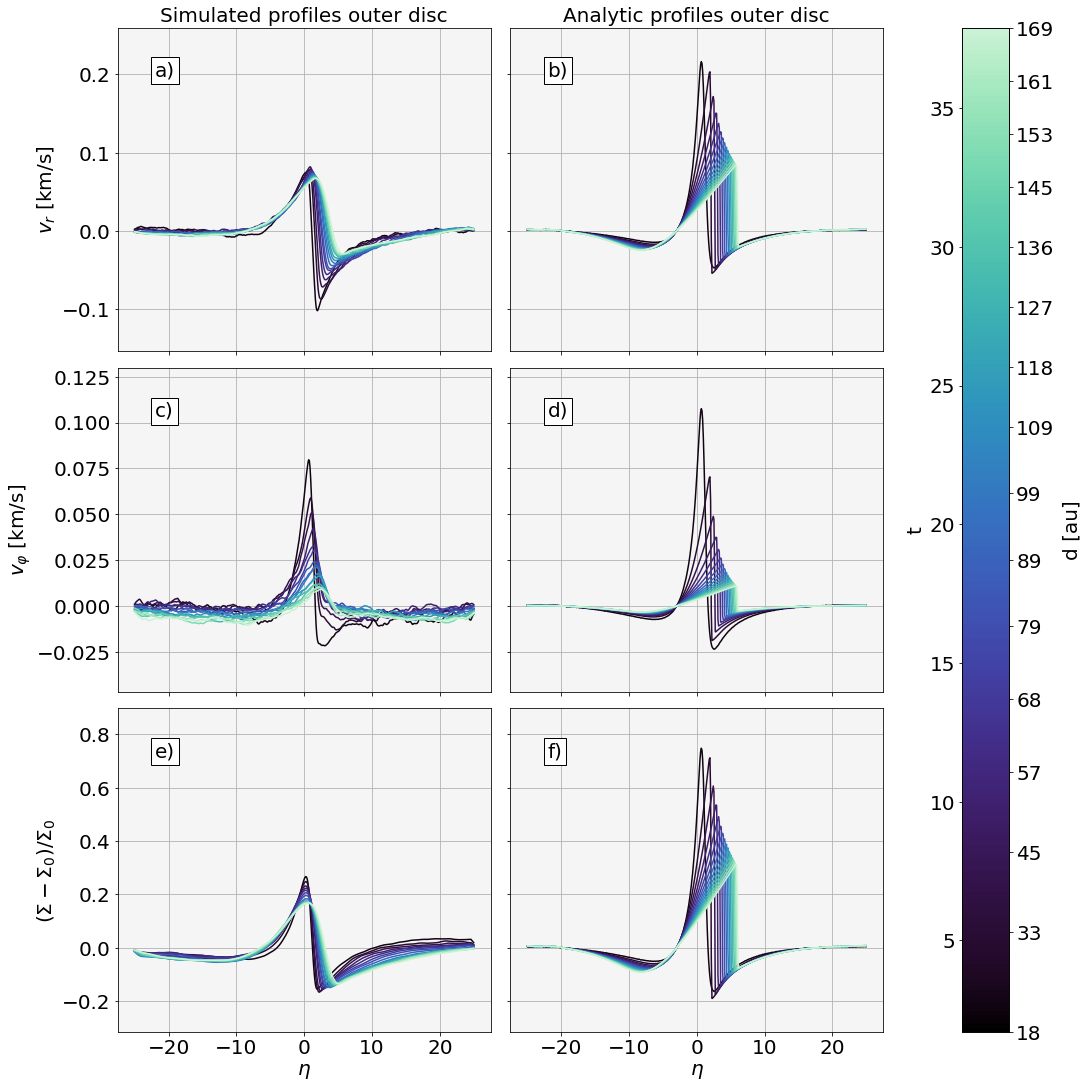

In [82]:
fig, ax = plt.subplots(3, 2, figsize = (14, 15), sharex=True, sharey = 'row', constrained_layout=True)
#plt.subplots_adjust(hspace=0.33)

t_out = t_outer
n = len(t_out)
norm = cl.Normalize(vmin=t_out.min(), vmax=t_out.max())
cmap = cm.ScalarMappable(norm=norm, cmap=cm.summer)
lac_cut = cmaps['cma:laguna'].colors
colors = lac_cut[:-20]
cmaps['cma:lacerta_cut'] = ListedColormap(colors, name="cma:lacerta_cut")
new_cmap = cm.ScalarMappable(norm=norm, cmap=cmaps['cma:lacerta_cut'])
cmap.set_array([])

dim_dist = 16
pdfp = np.zeros(dim_dist)
counter = 0

y_prof_max = np.max([np.max(vr_outer_int[0]), np.max(vr_a_outer.T[0])])
y_prof_min = np.min([np.min(vr_outer_int[0]), np.min(vr_a_outer.T[0])])
eps = 0.2 * np.max([np.abs(y_prof_max), np.abs(y_prof_min)])

for i in range(len(vr_outer_int)):
    if i%int(len(vr_outer_int)/15) == 0:
        N = int(i/(len(vr_outer_int)/15)) + 10
        pdfp[counter] = distance(R_grid_outer[i][0])
        counter += 1
        im1 = ax[0,0].plot(eta, np.convolve(vr_outer_int[i], np.ones(N)/N, mode='same'),
                           color = new_cmap.to_rgba(t_out[i] + 1))
ax[0,0].set_ylim(y_prof_min - eps, y_prof_max + eps)    
ax[0,0].tick_params(labelsize=20)
#ax[0,0].set_xlabel(r'$\eta$')
ax[0,0].set_ylabel(r'$v_r$ [km/s]', fontsize=20)
ax[0,0].set_title(r'Simulated profiles outer disc', fontsize=20)
ax[0,0].set_facecolor('whitesmoke')
ax[0,0].grid()
ax[0,0].text(0.10,0.85, r'a)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[0,0].transAxes)

for i in range(len(t_out)-1):
    if i%int(len(vr_outer_int)/15) == 0:
        idx = np.argmax(t_a_outer>t_out[i])    
        im2 = ax[0,1].plot(eta_a_outer, vr_a_outer.T[idx], color = new_cmap.to_rgba(t_out[i] + 1))
ax[0,1].set_ylim(y_prof_min - eps, y_prof_max + eps)  
ax[0,1].tick_params(labelsize=20)
#ax[0,1].set_xlabel(r'$\eta$')
#ax[0,1].set_ylabel(r'$v_r$ [km/s]', fontsize=20)
ax[0,1].set_title(r'Analytic profiles outer disc', fontsize=20)
ax[0,1].set_facecolor('whitesmoke')
ax[0,1].grid()
ax[0,1].text(0.10,0.85, r'b)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[0,1].transAxes)


y_prof_max = np.max([np.max(vphi_outer_int[0]), np.max(vphi_a_outer.T[0])])
y_prof_min = np.min([np.min(vphi_outer_int[0]), np.min(vphi_a_outer.T[0])])
eps = 0.2 * np.max([np.abs(y_prof_max), np.abs(y_prof_min)])

for i in range(len(vr_outer_int)):
    if i%int(len(vr_outer_int)/15) == 0:
        N = int(i/(len(vr_outer_int)/15)) + 10
        im1 = ax[1,0].plot(eta, np.convolve(vphi_outer_int[i], np.ones(N)/N, mode='same'),
                           color = new_cmap.to_rgba(t_out[i] + 1))
ax[1,0].set_ylim(y_prof_min - eps, y_prof_max + eps)    
ax[1,0].tick_params(labelsize=20)
#ax[1,0].set_xlabel(r'$\eta$')
ax[1,0].set_ylabel(r'$v_\varphi$ [km/s]', fontsize=20)
#ax[1,0].set_title(r'Simulated $v_\varphi$ profiles outer disc')
ax[1,0].set_facecolor('whitesmoke')
ax[1,0].grid()
ax[1,0].text(0.10,0.85, r'c)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[1,0].transAxes)

for i in range(len(t_out)-1):
    if i%int(len(vr_outer_int)/15) == 0:
        idx = np.argmax(t_a_outer>t_out[i])    
        im2 = ax[1,1].plot(eta_a_outer, vphi_a_outer.T[idx], color = new_cmap.to_rgba(t_out[i] + 1))
ax[1,1].set_ylim(y_prof_min - eps, y_prof_max + eps)  
ax[1,1].tick_params(labelsize=20)
#ax[1,1].set_xlabel(r'$\eta$')
#ax[1,1].set_ylabel(r'$v_\varphi$ [km/s]', fontsize=20)
#ax[1,1].set_title(r'Analytic $v_\varphi$ profiles outer disc')
ax[1,1].set_facecolor('whitesmoke')
ax[1,1].grid()
ax[1,1].text(0.10,0.85, r'd)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[1,1].transAxes)

y_prof_max = np.max([np.max(rho_outer_int[0]), np.max(dsigma_a_outer.T[0])])
y_prof_min = np.min([np.min(rho_outer_int[0]), np.min(dsigma_a_outer.T[0])])
eps = 0.2 * np.max([np.abs(y_prof_max), np.abs(y_prof_min)])

for i in range(len(rho_outer_int)):
    if i%int(len(vr_outer_int)/15) == 0:
        N = int(i/(len(vr_outer_int)/15)) + 10
        im1 = ax[2,0].plot(eta, np.convolve(rho_outer_int[i], np.ones(N)/N, mode='same'),
                           color = new_cmap.to_rgba(t_out[i] + 1))
ax[2,0].set_ylim(y_prof_min - eps, y_prof_max + eps)    
ax[2,0].tick_params(labelsize=20)
ax[2,0].set_xlabel(r'$\eta$', fontsize=20)
ax[2,0].set_ylabel(r'$ (\Sigma - \Sigma _0)/\Sigma _0$', fontsize=20)
#ax[2,0].set_title(r'Simulated $ (\Sigma - \Sigma _0)/\Sigma _0$ profiles outer disc')
ax[2,0].set_facecolor('whitesmoke')
ax[2,0].grid()
ax[2,0].text(0.10,0.85, r'e)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[2,0].transAxes)

for i in range(len(t_out)-1):
    if i%int(len(vr_outer_int)/15) == 0:
        idx = np.argmax(t_a_outer>t_out[i])    
        im2 = ax[2,1].plot(eta_a_outer, dsigma_a_outer.T[idx], color = new_cmap.to_rgba(t_out[i] + 1))
ax[2,1].set_ylim(y_prof_min - eps, y_prof_max + eps)  
ax[2,1].tick_params(labelsize=20)
ax[2,1].set_xlabel(r'$\eta$', fontsize=20)
#ax[2,1].set_ylabel(r'$ (\Sigma - \Sigma _0)/\Sigma _0$', fontsize=20)
#ax[2,1].set_title(r'Analytic $ (\Sigma - \Sigma _0)/\Sigma _0$ profiles outer disc')
ax[2,1].set_facecolor('whitesmoke')
ax[2,1].grid()
ax[2,1].text(0.10,0.85, r'f)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[2,1].transAxes)

#cbar_ax = fig.add_axes([0.27, 0.045, 0.50, 0.02])

cb = fig.colorbar(new_cmap, label = r't', ax = ax[:,1], shrink = 1)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r't', fontsize=20)
cb.ax.yaxis.set_label_position('left')
cb2 = cb.ax.twinx() 
cb2.set_ylim([pdfp[0], pdfp[-1]])
cb2.set_yticks([tic for tic in pdfp])
cb2.set_ylabel('d [au]', labelpad=8, fontsize=20)
cb2.tick_params(labelsize=20)

#plt.savefig(dir + "comp_as_prof_out.png", bbox_inches = 'tight');

### Inner Disc

Text(0, 0.5, 't')

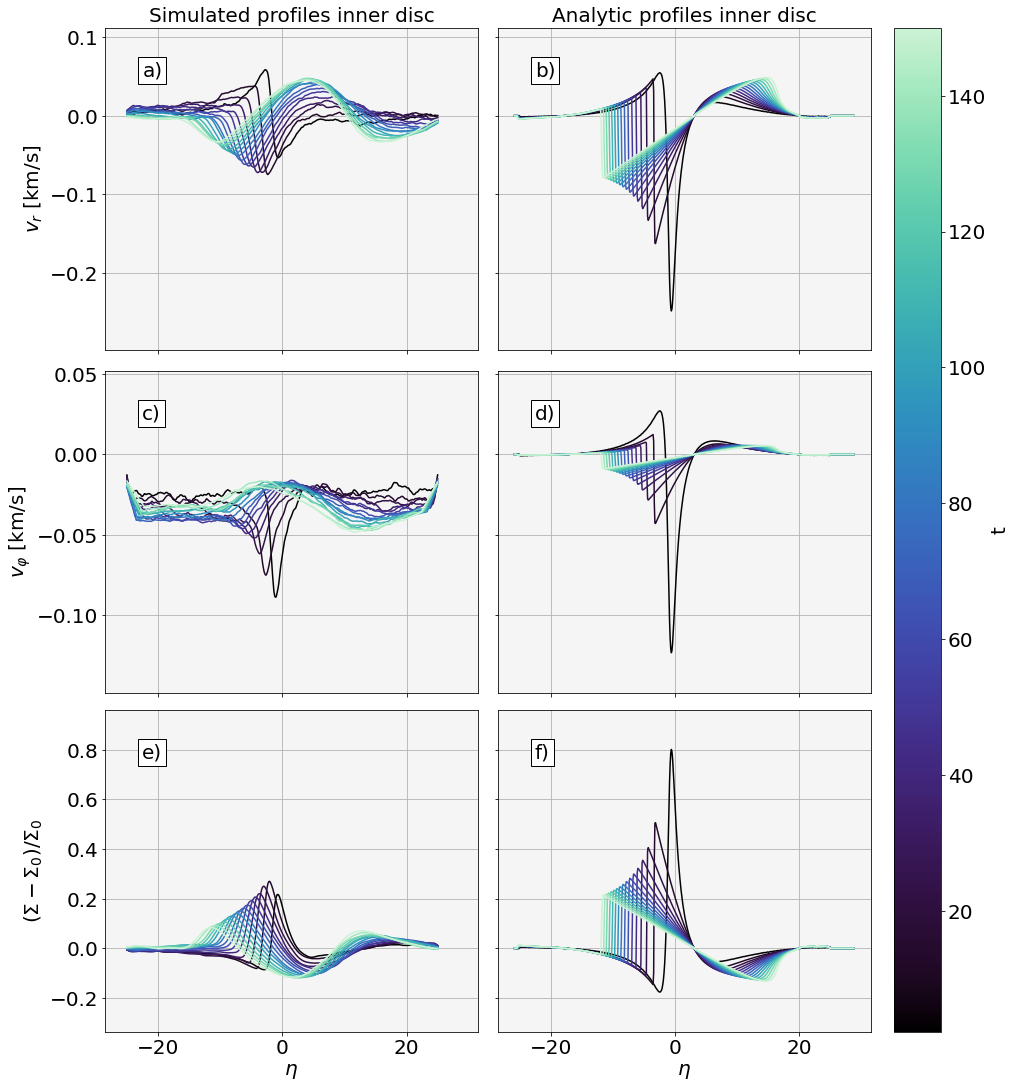

In [83]:
fig, ax = plt.subplots(3, 2, figsize = (14, 15), sharex = True, sharey = 'row', constrained_layout=True)
#plt.subplots_adjust(hspace=0.33)

t_out = t_inner
n = len(t_out)
norm = cl.Normalize(vmin=t_out.min(), vmax=t_out.max())
cmap = cm.ScalarMappable(norm=norm, cmap=cm.summer)
lac_cut = cmaps['cma:laguna'].colors
colors = lac_cut[:-20]
cmaps['cma:lacerta_cut'] = ListedColormap(colors, name="cma:lacerta_cut")
new_cmap = cm.ScalarMappable(norm=norm, cmap=cmaps['cma:lacerta_cut'])
cmap.set_array([])

pdfp = np.zeros(16)
counter = 0

y_prof_max = np.max([np.max(vr_inner_int[0]), np.max(vr_a_inner.T[0])])
y_prof_min = np.min([np.min(vr_inner_int[0]), np.min(vr_a_inner.T[0])])
eps = 0.2 * np.max([np.abs(y_prof_max), np.abs(y_prof_min)])

for i in range(len(vr_inner_int)):
    if i%int(len(vr_inner_int)/15) == 0:
        N = int(3*i/(len(vr_inner_int)/15)) + 10
        pdfp[counter] = distance(R_grid_inner[i][0])
        counter += 1
        im1 = ax[0,0].plot(eta, np.convolve(vr_inner_int[i], np.ones(N)/N, mode='same'),
                           color = new_cmap.to_rgba(t_out[i] + 1))
ax[0,0].set_ylim(y_prof_min - eps, y_prof_max + eps)   
ax[0,0].tick_params(labelsize=20)
#ax[0,0].set_xlabel(r'$\eta$')
ax[0,0].set_ylabel(r'$v_r$ [km/s]', fontsize = 20)
ax[0,0].set_title(r'Simulated profiles inner disc', fontsize = 20)
ax[0,0].set_facecolor('whitesmoke')
ax[0,0].grid()
ax[0,0].text(0.10,0.85, r'a)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[0,0].transAxes)

for i in range(len(t_out)-1):
    if i%int(len(vr_inner_int)/15) == 0:
        idx = np.argmax(t_a_inner>t_out[i])    
        im2 = ax[0,1].plot(eta_a_inner, vr_a_inner.T[idx], color = new_cmap.to_rgba(t_out[i] + 1))
ax[0,1].set_ylim(y_prof_min - eps, y_prof_max + eps)  
ax[0,1].tick_params(labelsize=20)
#ax[0,1].set_xlabel(r'$\eta$')
#ax[0,1].set_ylabel(r'$v_r$ [km/s]')
ax[0,1].set_title(r'Analytic profiles inner disc', fontsize =20)
ax[0,1].set_facecolor('whitesmoke')
ax[0,1].grid()
ax[0,1].text(0.10,0.85, r'b)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[0,1].transAxes)

y_prof_max = np.max([np.max(vphi_inner_int[0]), np.max(vphi_a_inner.T[0])])
y_prof_min = np.min([np.min(vphi_inner_int[0]), np.min(vphi_a_inner.T[0])])
eps = 0.2 * np.max([np.abs(y_prof_max), np.abs(y_prof_min)])

for i in range(len(vr_inner_int)):
    if i%int(len(vr_inner_int)/15) == 0:
        N = int(3*i/(len(vr_inner_int)/15)) + 10
        im1 = ax[1,0].plot(eta, np.convolve(vphi_inner_int[i], np.ones(N)/N, mode='same'),
                           color = new_cmap.to_rgba(t_out[i] + 1))
ax[1,0].set_ylim(y_prof_min - eps, y_prof_max + eps)    
ax[1,0].tick_params(labelsize=20)
#ax[1,0].set_xlabel(r'$\eta$')
ax[1,0].set_ylabel(r'$v_\varphi$ [km/s]', fontsize =20)
#ax[1,0].set_title(r'Simulated $v_\varphi$ profiles inner disc', fontsize =20)
ax[1,0].set_facecolor('whitesmoke')
ax[1,0].grid()
ax[1,0].text(0.10,0.85, r'c)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[1,0].transAxes)

for i in range(len(t_out)-1):
    if i%int(len(vr_inner_int)/15) == 0:
        idx = np.argmax(t_a_inner>t_out[i])    
        im2 = ax[1,1].plot(eta_a_inner, vphi_a_inner.T[idx], color = new_cmap.to_rgba(t_out[i] + 1))
ax[1,1].set_ylim(y_prof_min - eps, y_prof_max + eps)  
ax[1,1].tick_params(labelsize=20)
#ax[1,1].set_xlabel(r'$\eta$')
#ax[1,1].set_ylabel(r'$v_\varphi$ [km/s]')
#ax[1,1].set_title(r'Analytic $v_\varphi$ profiles inner disc', fontsize =20)
ax[1,1].set_facecolor('whitesmoke')
ax[1,1].grid()
ax[1,1].text(0.10,0.85, r'd)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[1,1].transAxes)

y_prof_max = np.max([np.max(rho_inner_int[0]), np.max(dsigma_a_inner.T[0])])
y_prof_min = np.min([np.min(rho_inner_int[0]), np.min(dsigma_a_inner.T[0])])
eps = 0.2 * np.max([np.abs(y_prof_max), np.abs(y_prof_min)])

for i in range(len(rho_inner_int)):
    if i%int(len(vr_inner_int)/15) == 0:
        N = int(i/(len(vr_inner_int)/15)) + 10
        im1 = ax[2,0].plot(eta, np.convolve(rho_inner_int[i], np.ones(N)/N, mode='same'),
                           color = new_cmap.to_rgba(t_out[i] + 1))
ax[2,0].set_ylim(y_prof_min - eps, y_prof_max + eps)    
ax[2,0].tick_params(labelsize=20)
ax[2,0].set_xlabel(r'$\eta$', fontsize =20)
ax[2,0].set_ylabel(r'$ (\Sigma - \Sigma _0)/\Sigma _0$', fontsize =20)
#ax[2,0].set_title(r'Simulated $ (\Sigma - \Sigma _0)/\Sigma _0$ profiles inner disc', fontsize =20)
ax[2,0].set_facecolor('whitesmoke')
ax[2,0].grid()
ax[2,0].text(0.10,0.85, r'e)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[2,0].transAxes)

for i in range(len(t_out)-1):
    if i%int(len(vr_inner_int)/15) == 0:
        idx = np.argmax(t_a_inner>t_out[i])    
        im2 = ax[2,1].plot(eta_a_inner, dsigma_a_inner.T[idx], color = new_cmap.to_rgba(t_out[i] + 1))
ax[2,1].set_ylim(y_prof_min - eps, y_prof_max + eps)  
ax[2,1].tick_params(labelsize=20)
ax[2,1].set_xlabel(r'$\eta$', fontsize =20)
#ax[2,1].set_ylabel(r'$ (\Sigma - \Sigma _0)/\Sigma _0$')
#ax[2,1].set_title(r'Analytic $ (\Sigma - \Sigma _0)/\Sigma _0$ profiles inner disc', fontsize =20)
ax[2,1].set_facecolor('whitesmoke')
ax[2,1].grid()
ax[2,1].text(0.10,0.85, r'f)', bbox = dict(facecolor = 'white', alpha = 1), fontsize=20, transform=ax[2,1].transAxes)

#cbar_ax = fig.add_axes([0.27, 0.045, 0.50, 0.02])

cb = fig.colorbar(new_cmap, label = r't', ax = ax[:,1], shrink = 1)
cb.ax.tick_params(labelsize=20)
cb.ax.set_ylabel(r't', fontsize=20)
#plt.savefig(dir + "comp_as_prof_in.png", bbox_inches = 'tight');